In [1]:
import pandas as pd
import duckdb as duckdb
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_PATH_BASE_VM = '/home/guadalupealesandro/buckets/b1/datasets/competencia_02_crudo.csv.gz'

In [3]:
df = pd.read_csv(DATA_PATH_BASE_VM)

In [7]:
# Cantidad de ceros por columna y período
#zeros_por_periodo = df.groupby('foto_mes').apply(lambda x: (x == 0).sum())
#print(zeros_por_periodo)

          numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
foto_mes                                                                       
201901                    0         0            1542       123408     12759   
201902                    0         0            1514       124535     13320   
201903                    0         0            1511       125100     12907   
201904                    0         0            1602       125668     13012   
201905                    0         0            1606       126329     12310   
201906                    0         0            1659       127854     12737   
201907                    0         0            1654       129370     12571   
201908                    0         0            1743       131233     12587   
201909                    0         0            1722       132840     12696   
201910                    0         0            1769       135090     12586   
201911                    0         0   

/tmp/ipykernel_5165/3109746406.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zeros_por_periodo = df.groupby('foto_mes').apply(lambda x: (x == 0).sum())


In [7]:
def crear_clase_ternaria(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crea la clase ternaria para un DataFrame de clientes usando DuckDB.
    Devuelve el DataFrame original con columna 'clase_ternaria'.
    """
    #logger.info("Definiendo variable target")

    # Conexión en memoria
    conn = duckdb.connect(database=':memory:', read_only=False)

    # Registro del DataFrame como tabla temporal
    conn.register("df_tmp", df)

    # Crear la clase ternaria
    conn.execute("""
    CREATE OR REPLACE TABLE clases AS
    WITH periodos AS (
        SELECT 
            numero_de_cliente,
            foto_mes,
            CAST(foto_mes / 100 AS INTEGER) * 12 + (foto_mes % 100) AS periodo0
        FROM df_tmp
    ),
    max_periodo AS (
        SELECT MAX(periodo0) AS max_periodo0 FROM periodos
    )
    SELECT
        d.numero_de_cliente,
        d.foto_mes,
        CASE
            WHEN d.periodo0 <= m.max_periodo0 - 1
                AND NOT EXISTS (
                    SELECT 1
                    FROM periodos p
                    WHERE p.numero_de_cliente = d.numero_de_cliente
                    AND p.periodo0 = d.periodo0 + 1
                ) THEN 'BAJA+1'
            WHEN d.periodo0 <= m.max_periodo0 - 2
                AND NOT EXISTS (
                    SELECT 1
                    FROM periodos p
                    WHERE p.numero_de_cliente = d.numero_de_cliente
                    AND p.periodo0 = d.periodo0 + 2
                ) THEN 'BAJA+2'
            ELSE 'CONTINUA'
        END AS clase_ternaria
    FROM periodos d
    CROSS JOIN max_periodo m
    """)

    # Resumen por clase y mes
    resumen_clase_mes = conn.execute("""
        SELECT 
            clase_ternaria,
            foto_mes,
            COUNT(*) AS cantidad_clientes
        FROM clases
        GROUP BY clase_ternaria, foto_mes
        ORDER BY clase_ternaria, foto_mes
    """).df()

    pivot_df = resumen_clase_mes.pivot(index='clase_ternaria', columns='foto_mes', values='cantidad_clientes').fillna(0)
    print(pivot_df)

    # Join con el DataFrame original
    df_final = conn.execute("""
        SELECT 
            df_tmp.*,
            c.clase_ternaria
        FROM df_tmp
        LEFT JOIN clases c
            ON df_tmp.numero_de_cliente = c.numero_de_cliente
           AND df_tmp.foto_mes = c.foto_mes
    """).df()

    # Log resumen final
    n_continua = (df_final['clase_ternaria'] == "CONTINUA").sum()
    n_baja1 = (df_final['clase_ternaria'] == "BAJA+1").sum()
    n_baja2 = (df_final['clase_ternaria'] == "BAJA+2").sum()
    total_bajas = n_baja1 + n_baja2

    #logger.info(f"Clase ternaria creada: CONTINUA={n_continua}, BAJA+1={n_baja1}, BAJA+2={n_baja2}, Total bajas={total_bajas}")

    return df_final

In [10]:
df = crear_clase_ternaria(df)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

foto_mes          201901    201902    201903    201904    201905    201906  \
clase_ternaria                                                               
BAJA+1             645.0     733.0     708.0     756.0     517.0     696.0   
BAJA+2             729.0     707.0     751.0     514.0     692.0     608.0   
CONTINUA        122899.0  123961.0  124508.0  125268.0  125993.0  127430.0   

foto_mes          201907    201908    201909    201910  ...    202011  \
clase_ternaria                                          ...             
BAJA+1             611.0     683.0     581.0     594.0  ...     456.0   
BAJA+2             680.0     577.0     582.0     618.0  ...     616.0   
CONTINUA        128977.0  130883.0  132594.0  134798.0  ...  159178.0   

foto_mes          202012    202101    202102    202103    202104    202105  \
clase_ternaria                                                               
BAJA+1             622.0     622.0     831.0    1039.0     955.0    1134.0   
BAJA+2   

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
def convertir_clase_ternaria_a_target(df: pd.DataFrame, baja_2_1=True) -> pd.DataFrame:
    """
    Convierte clase_ternaria a target binario usando SQL en DuckDB:
    - CONTINUA = 0
    - Si baja_2_1=True: BAJA+1 y BAJA+2 = 1
    - Si baja_2_1=False: BAJA+1 = 0 y BAJA+2 = 1
    
    Args:
        df: DataFrame con columna 'clase_ternaria'
        baja_2_1: Booleano que indica si se considera BAJA+1 como positivo
        
    Returns:
        pd.DataFrame: DataFrame con clase_ternaria convertida a valores binarios (0, 1)
    """
    # Conexión en memoria
    conn = duckdb.connect(database=':memory:', read_only=False)
   
    # Crear tabla temporal a partir del DataFrame
    conn.register("df_tmp", df)
    
    # Contar valores originales para logging
    valores_orig = conn.execute("""
        SELECT 
            clase_ternaria,
            COUNT(*) as count
        FROM df_tmp
        GROUP BY clase_ternaria
    """).df()
    
    n_continua_orig = valores_orig[valores_orig['clase_ternaria'] == 'CONTINUA']['count'].sum()
    n_baja1_orig = valores_orig[valores_orig['clase_ternaria'] == 'BAJA+1']['count'].sum()
    n_baja2_orig = valores_orig[valores_orig['clase_ternaria'] == 'BAJA+2']['count'].sum()
   
    # Convertir con SQL usando CASE según baja_2_1
    if baja_2_1:
        query = """
            SELECT * EXCLUDE (clase_ternaria),
                CASE
                    WHEN clase_ternaria = 'CONTINUA' THEN 0
                    ELSE 1
                END AS clase_ternaria
            FROM df_tmp
        """
    else:
        query = """
            SELECT * EXCLUDE (clase_ternaria),
                CASE
                    WHEN clase_ternaria = 'BAJA+2' THEN 1
                    ELSE 0
                END AS clase_ternaria
            FROM df_tmp
        """
    
    df_result = conn.execute(query).df()
   
    # Log de la conversión
    n_ceros = (df_result['clase_ternaria'] == 0).sum()
    n_unos = (df_result['clase_ternaria'] == 1).sum()
    total = n_ceros + n_unos
   
    #logger.info(f"Conversión completada:")
    #logger.info(f"  Original - CONTINUA: {n_continua_orig}, BAJA+1: {n_baja1_orig}, BAJA+2: {n_baja2_orig}")
    #logger.info(f"  Binario - 0: {n_ceros}, 1: {n_unos}")
    #logger.info(f"  Distribución: {n_unos/total*100:.2f}% casos positivos")
   
    conn.close()
    
    return df_result

In [11]:
df = convertir_clase_ternaria_a_target(df,baja_2_1=False )

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total de variables numéricas: 153
Periodos: [np.int64(201901), np.int64(201902), np.int64(201903), np.int64(201904), np.int64(201905), np.int64(201906), np.int64(201907), np.int64(201908), np.int64(201909), np.int64(201910), np.int64(201911), np.int64(201912), np.int64(202001), np.int64(202002), np.int64(202003), np.int64(202004), np.int64(202005), np.int64(202006), np.int64(202007), np.int64(202008), np.int64(202009), np.int64(202010), np.int64(202011), np.int64(202012), np.int64(202101), np.int64(202102), np.int64(202103), np.int64(202104), np.int64(202105), np.int64(202106), np.int64(202107), np.int64(202108)]
Clases: [np.int32(0), np.int32(1)]

Generando 10 figuras con gráficos...


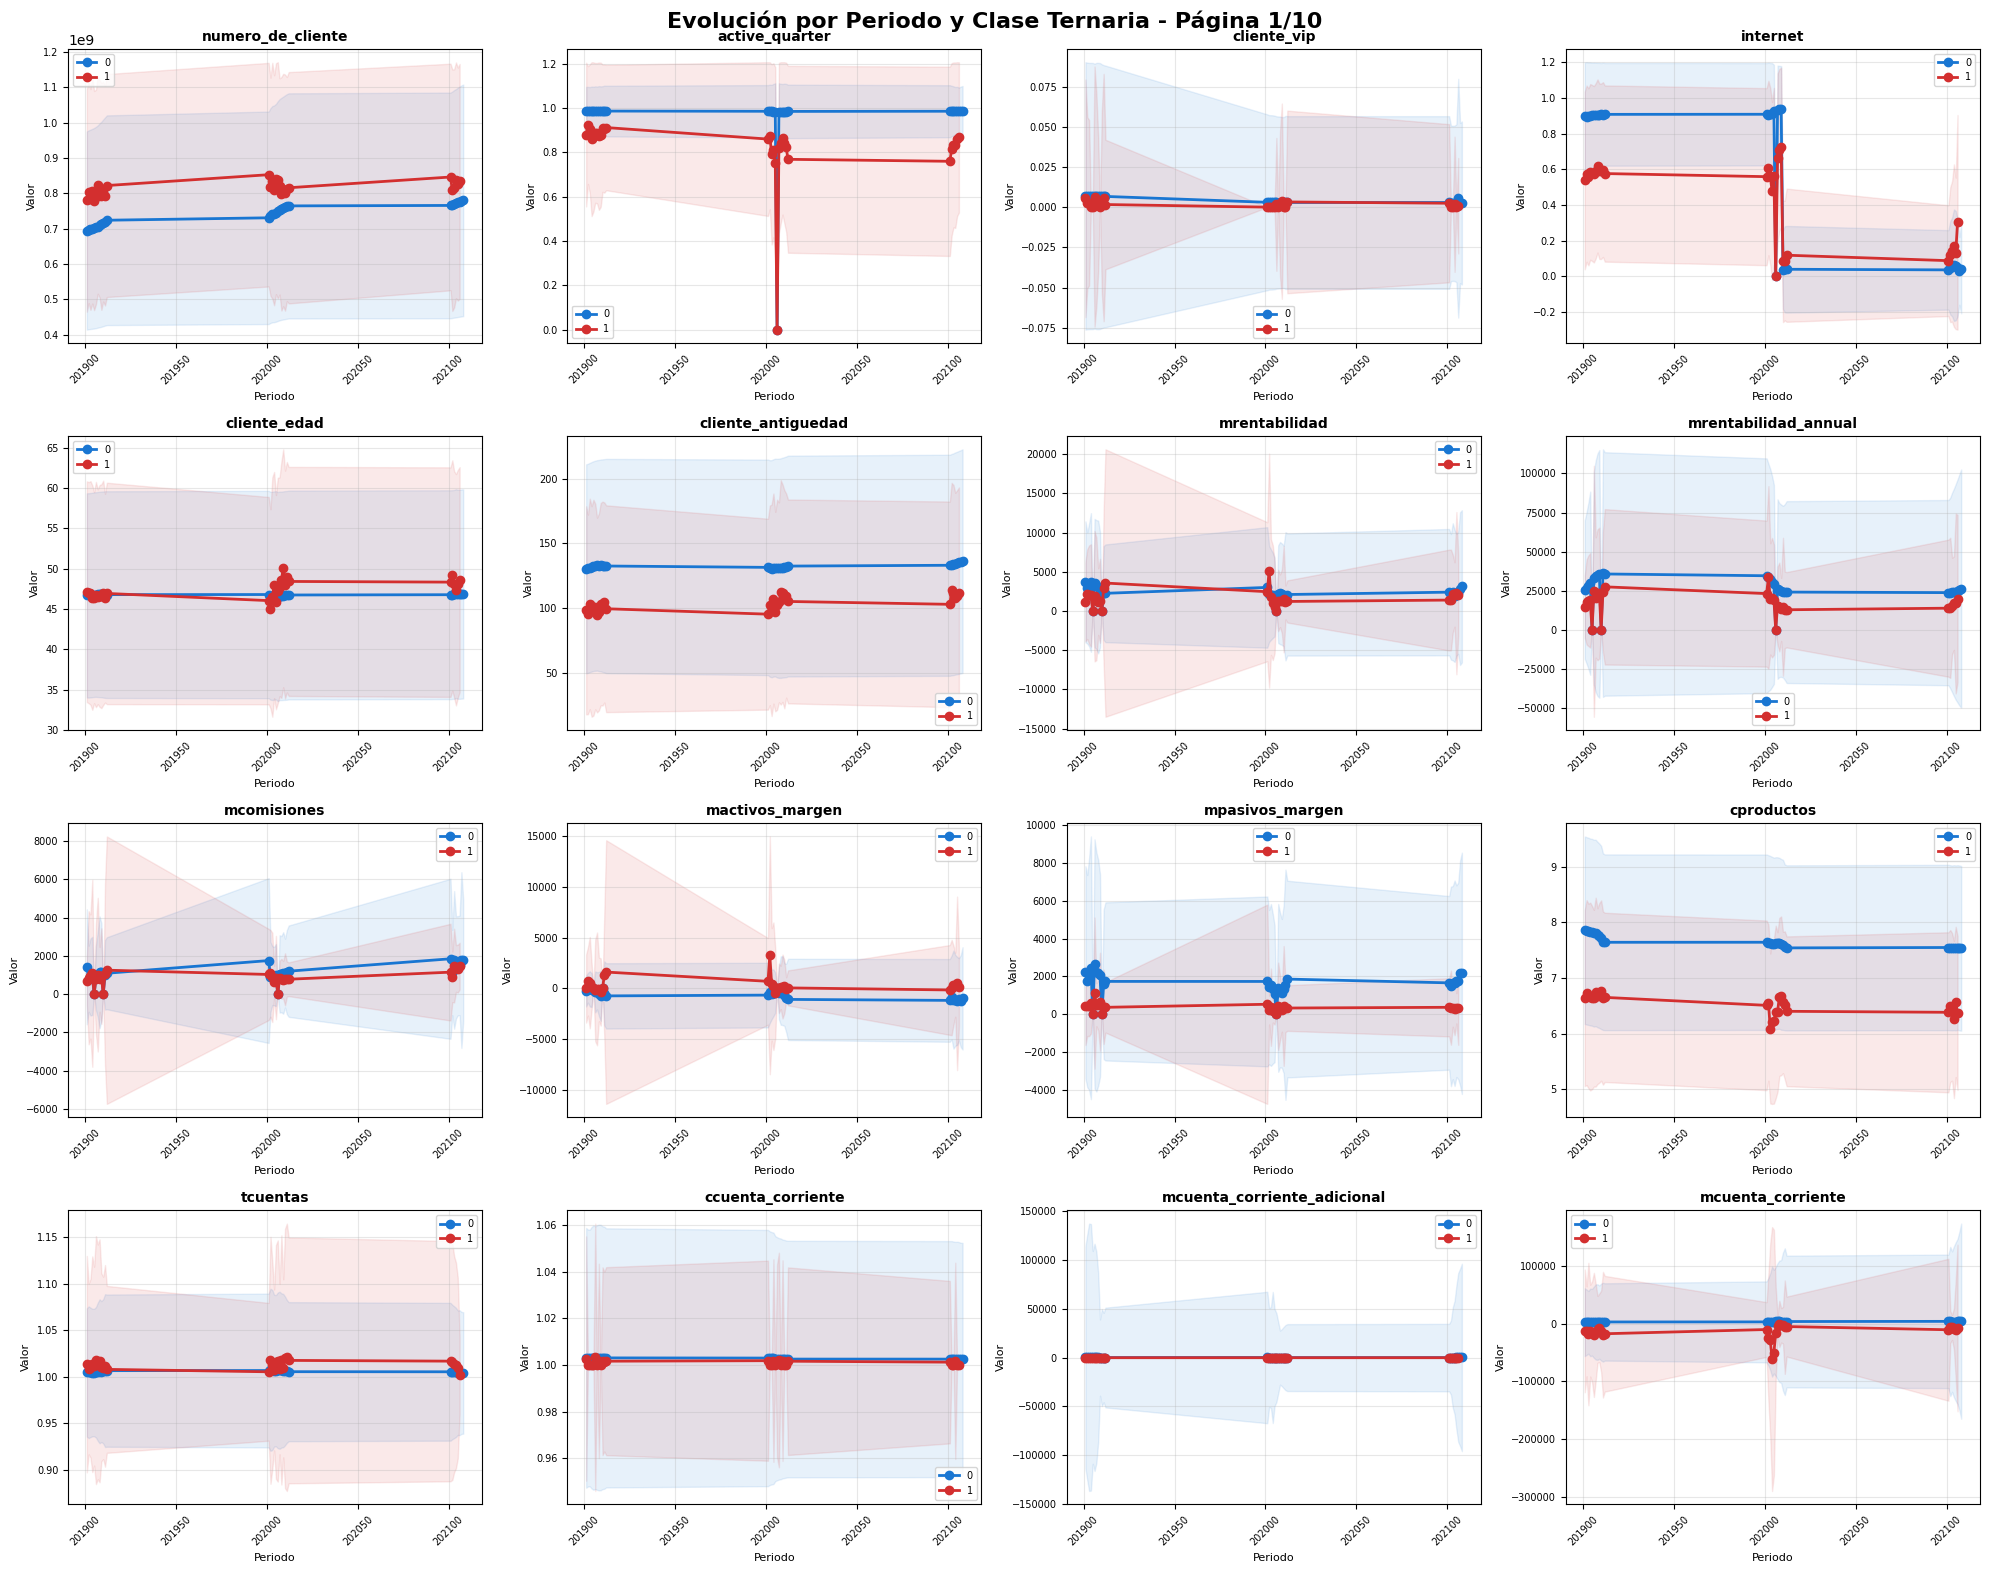

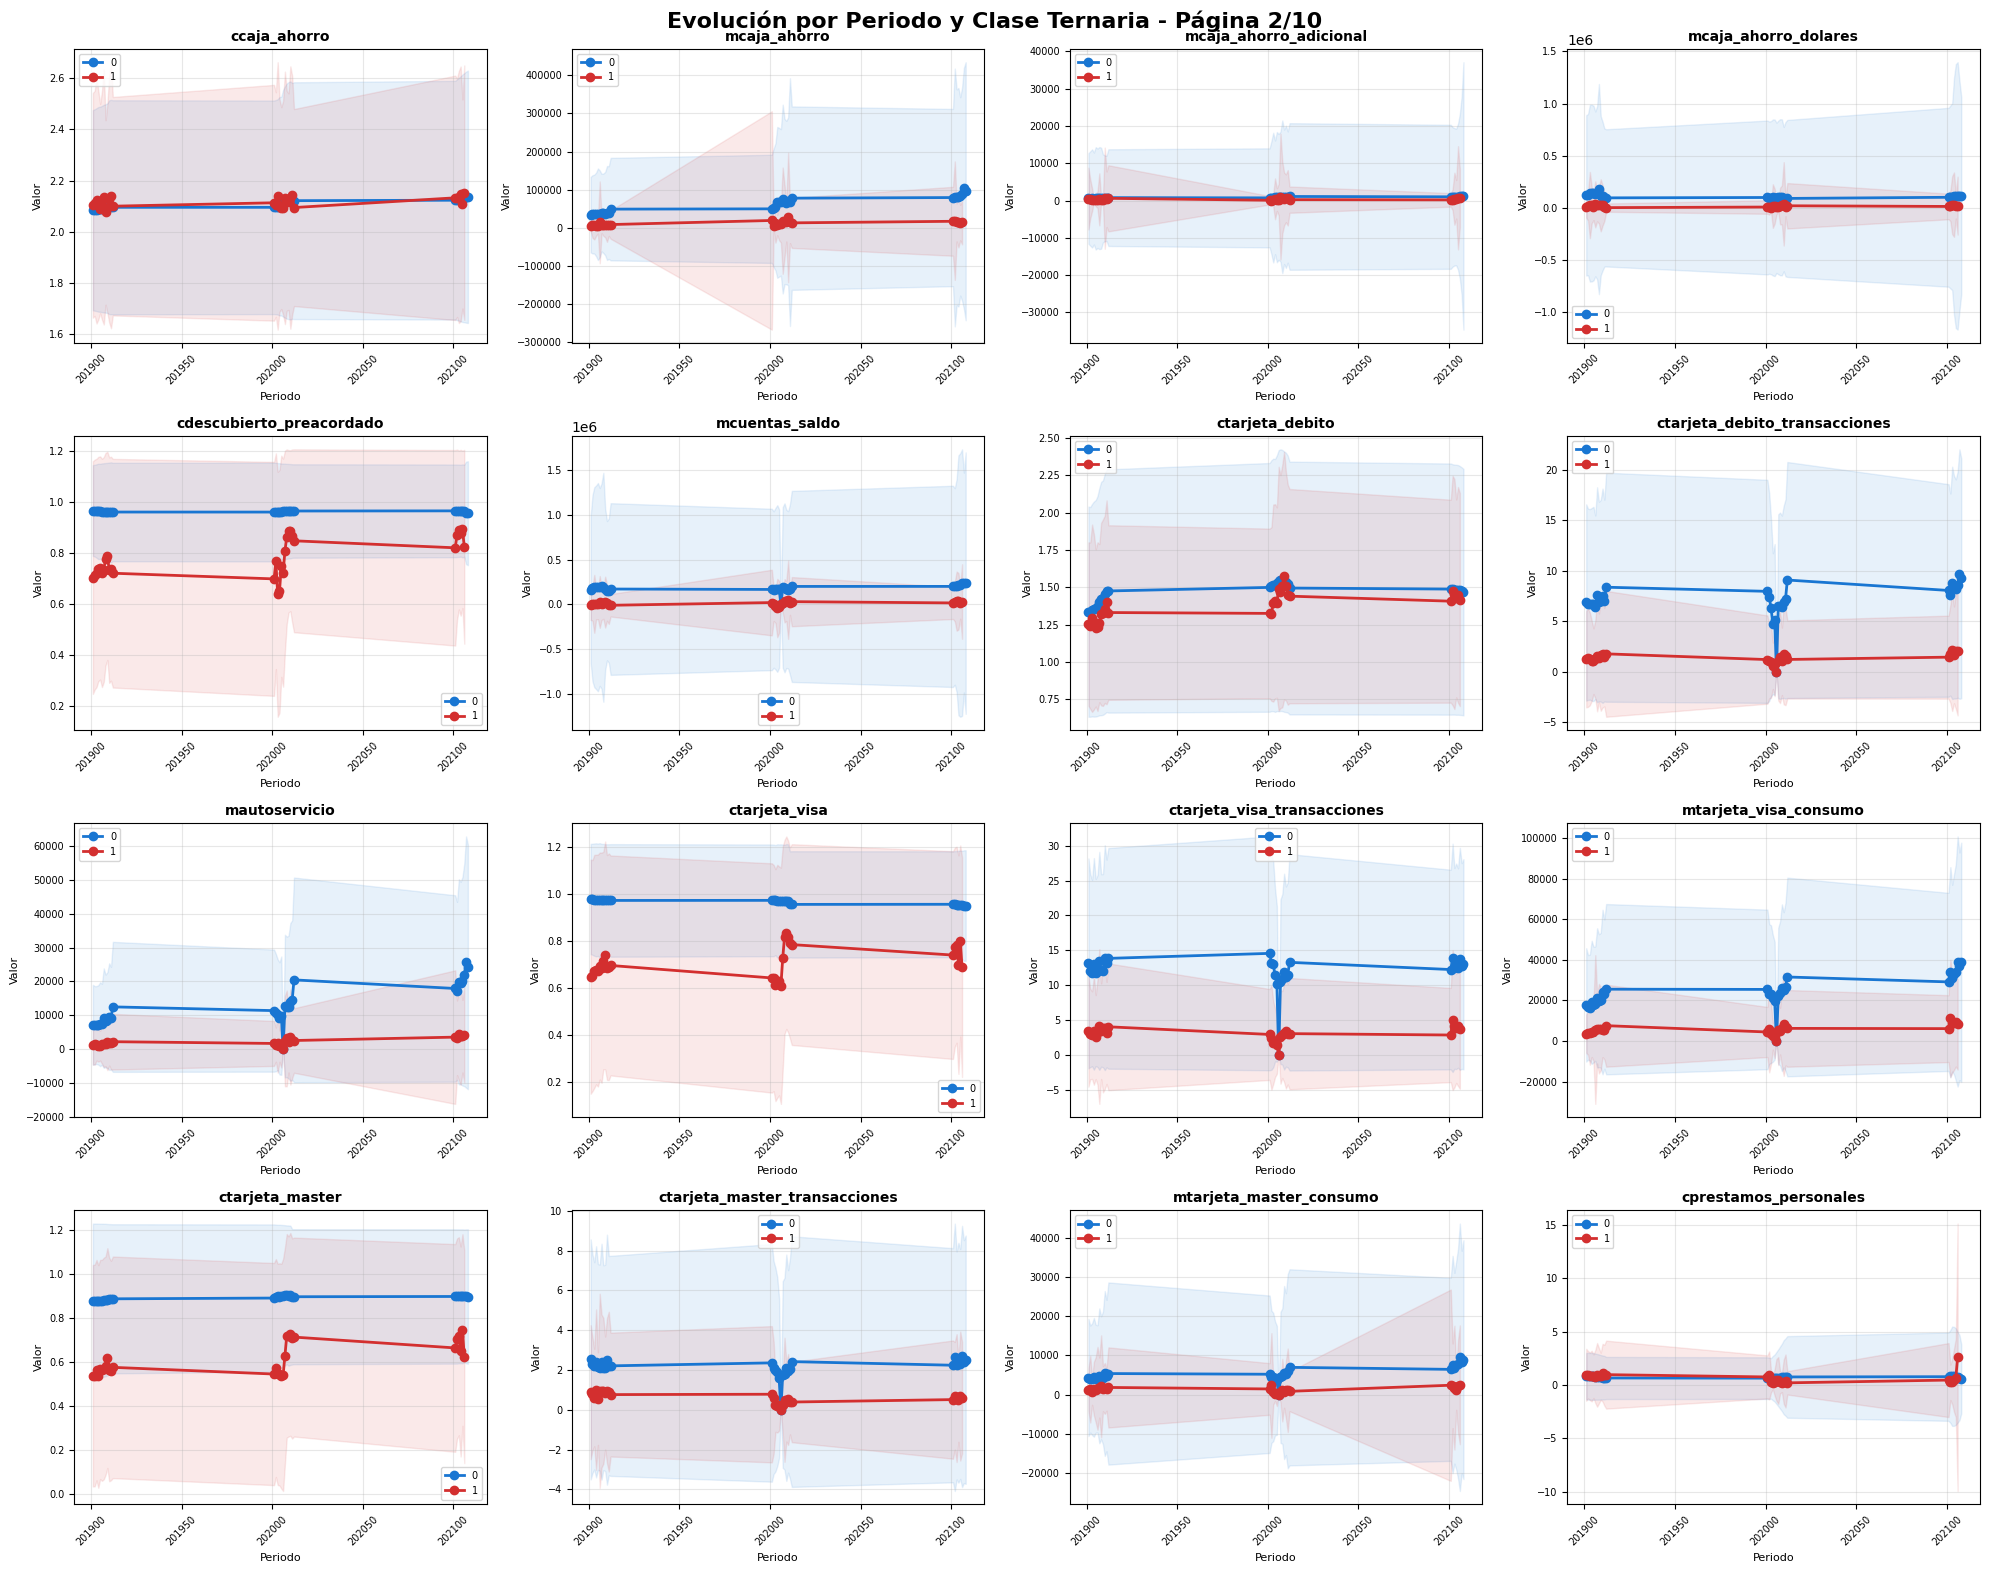

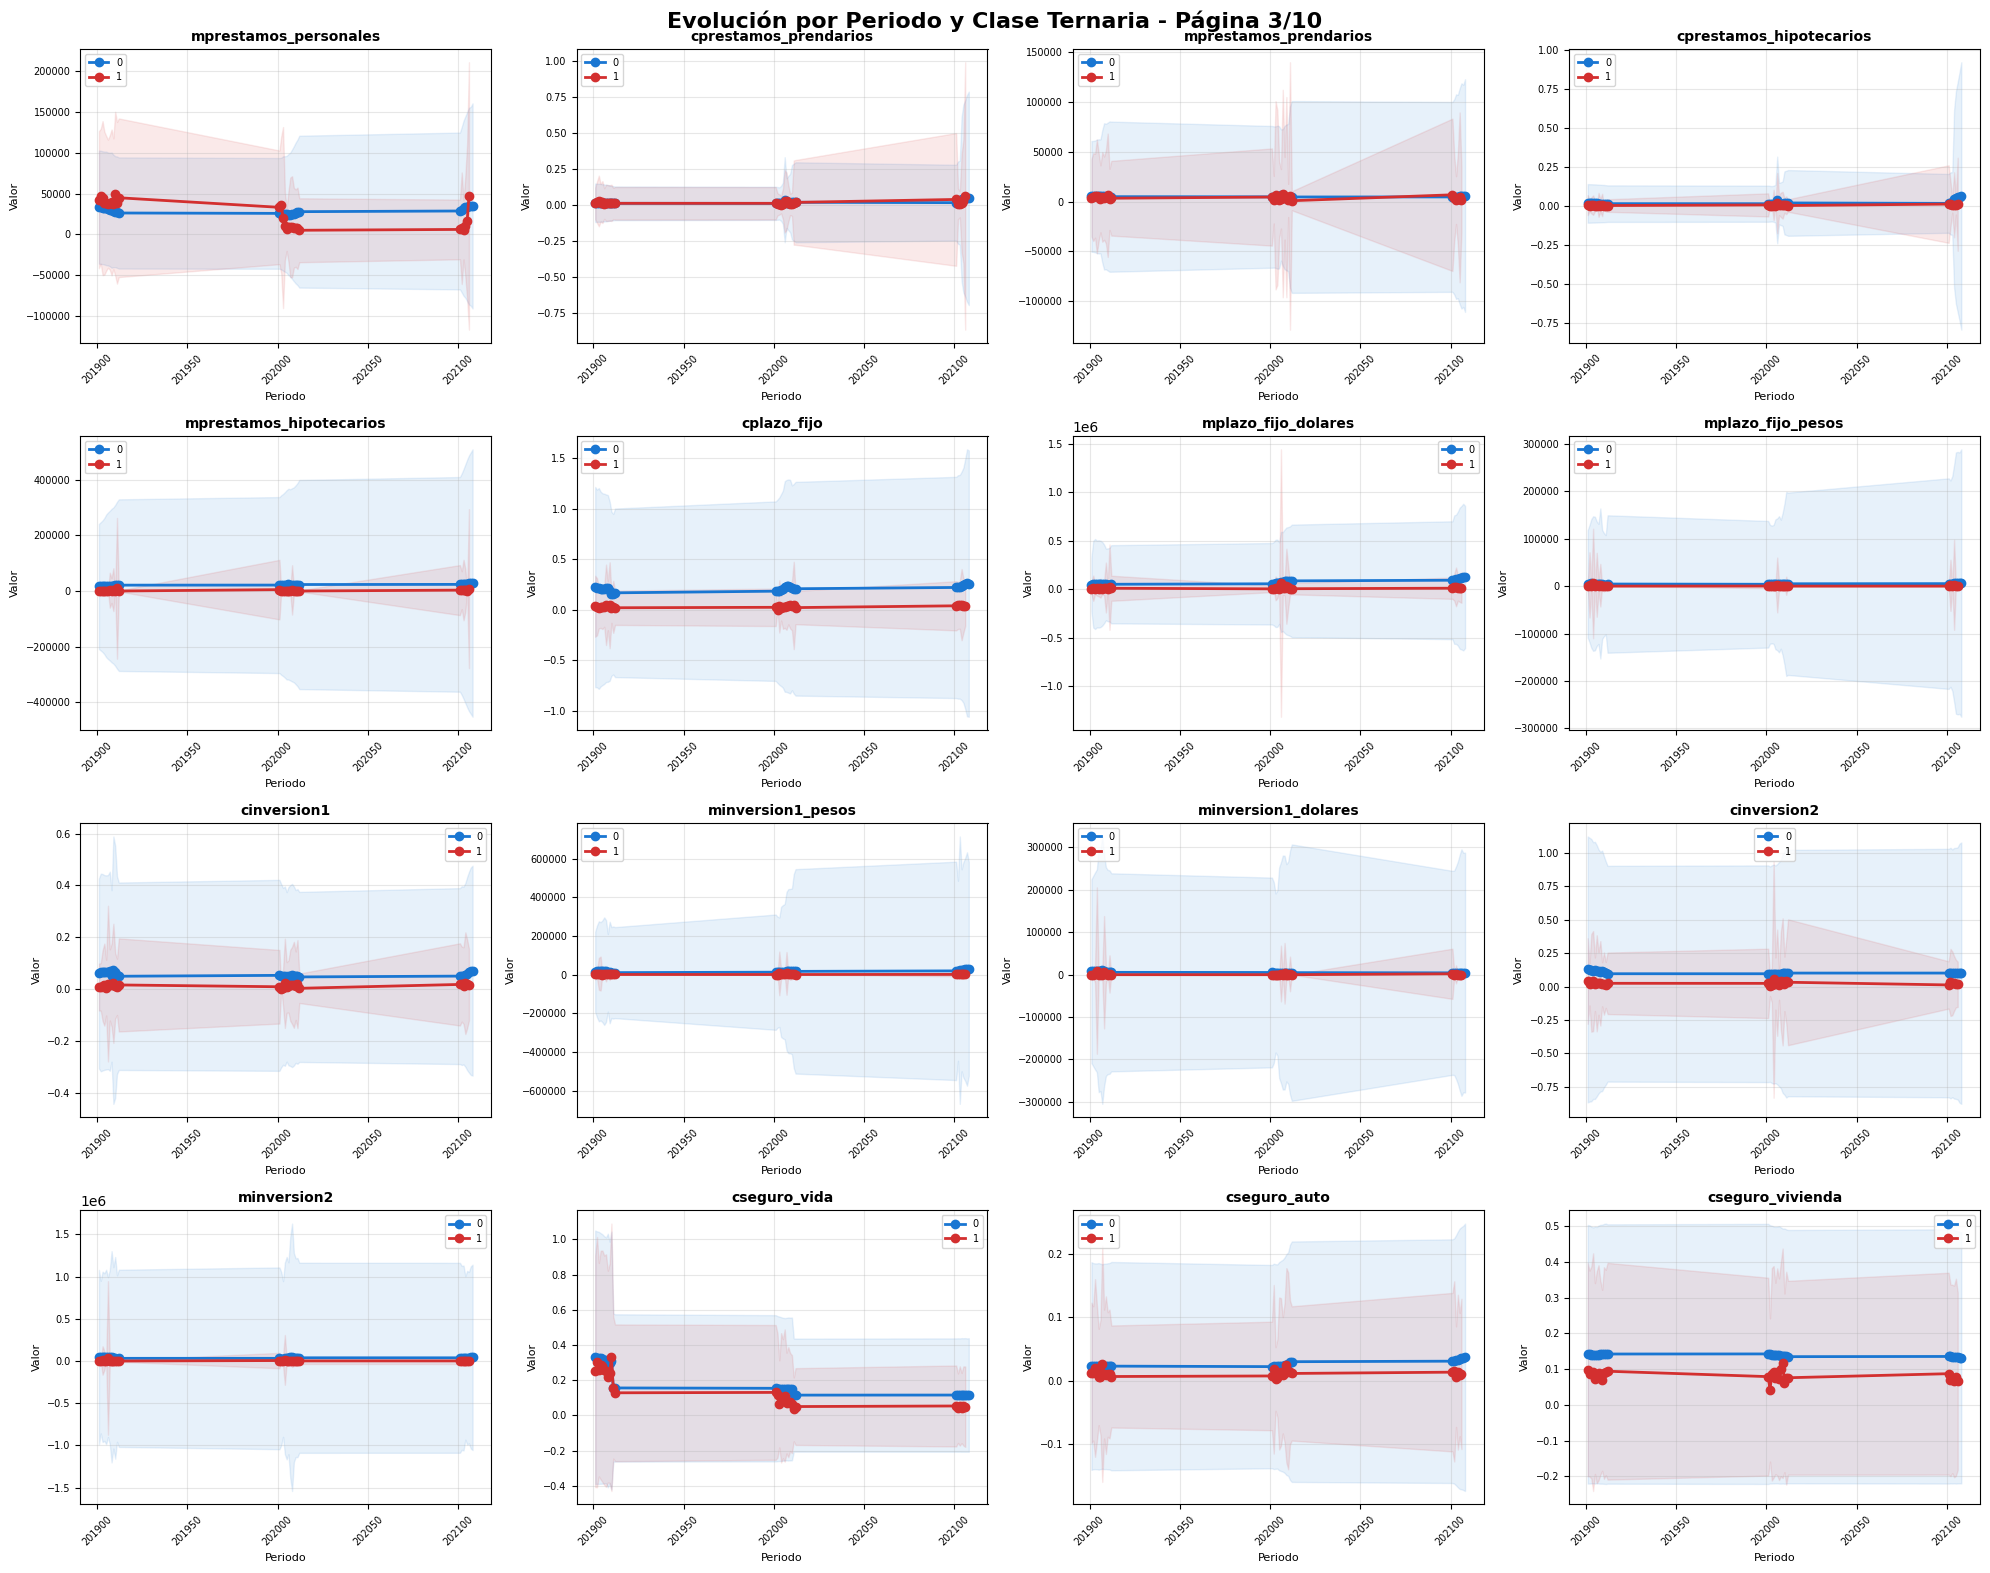

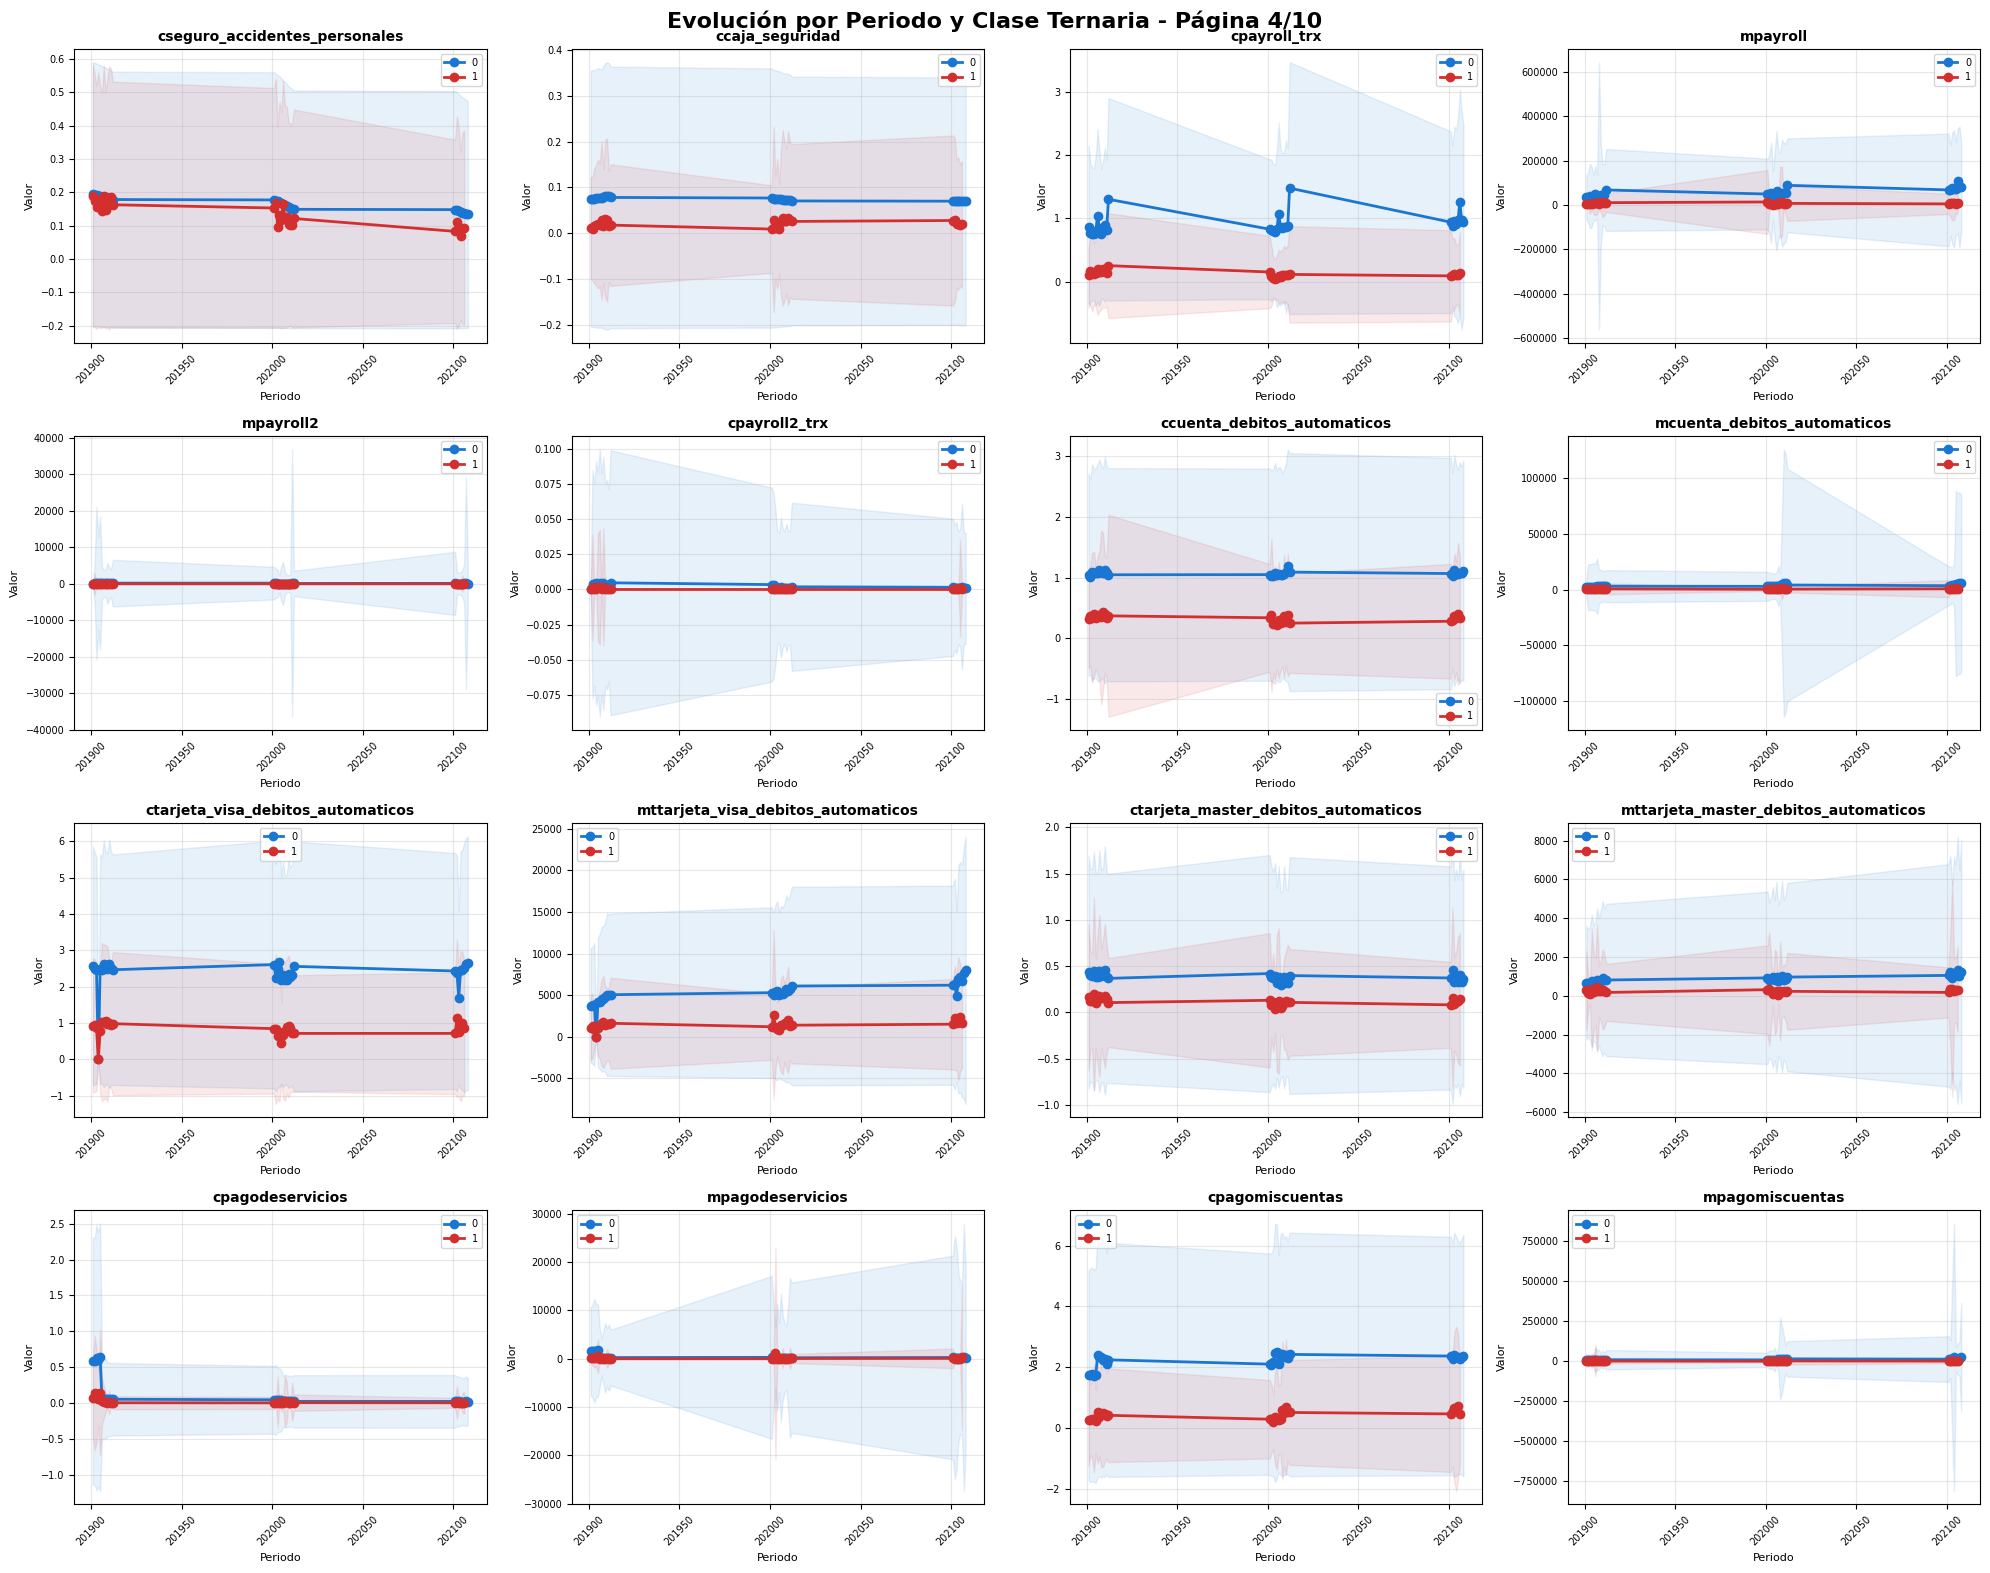

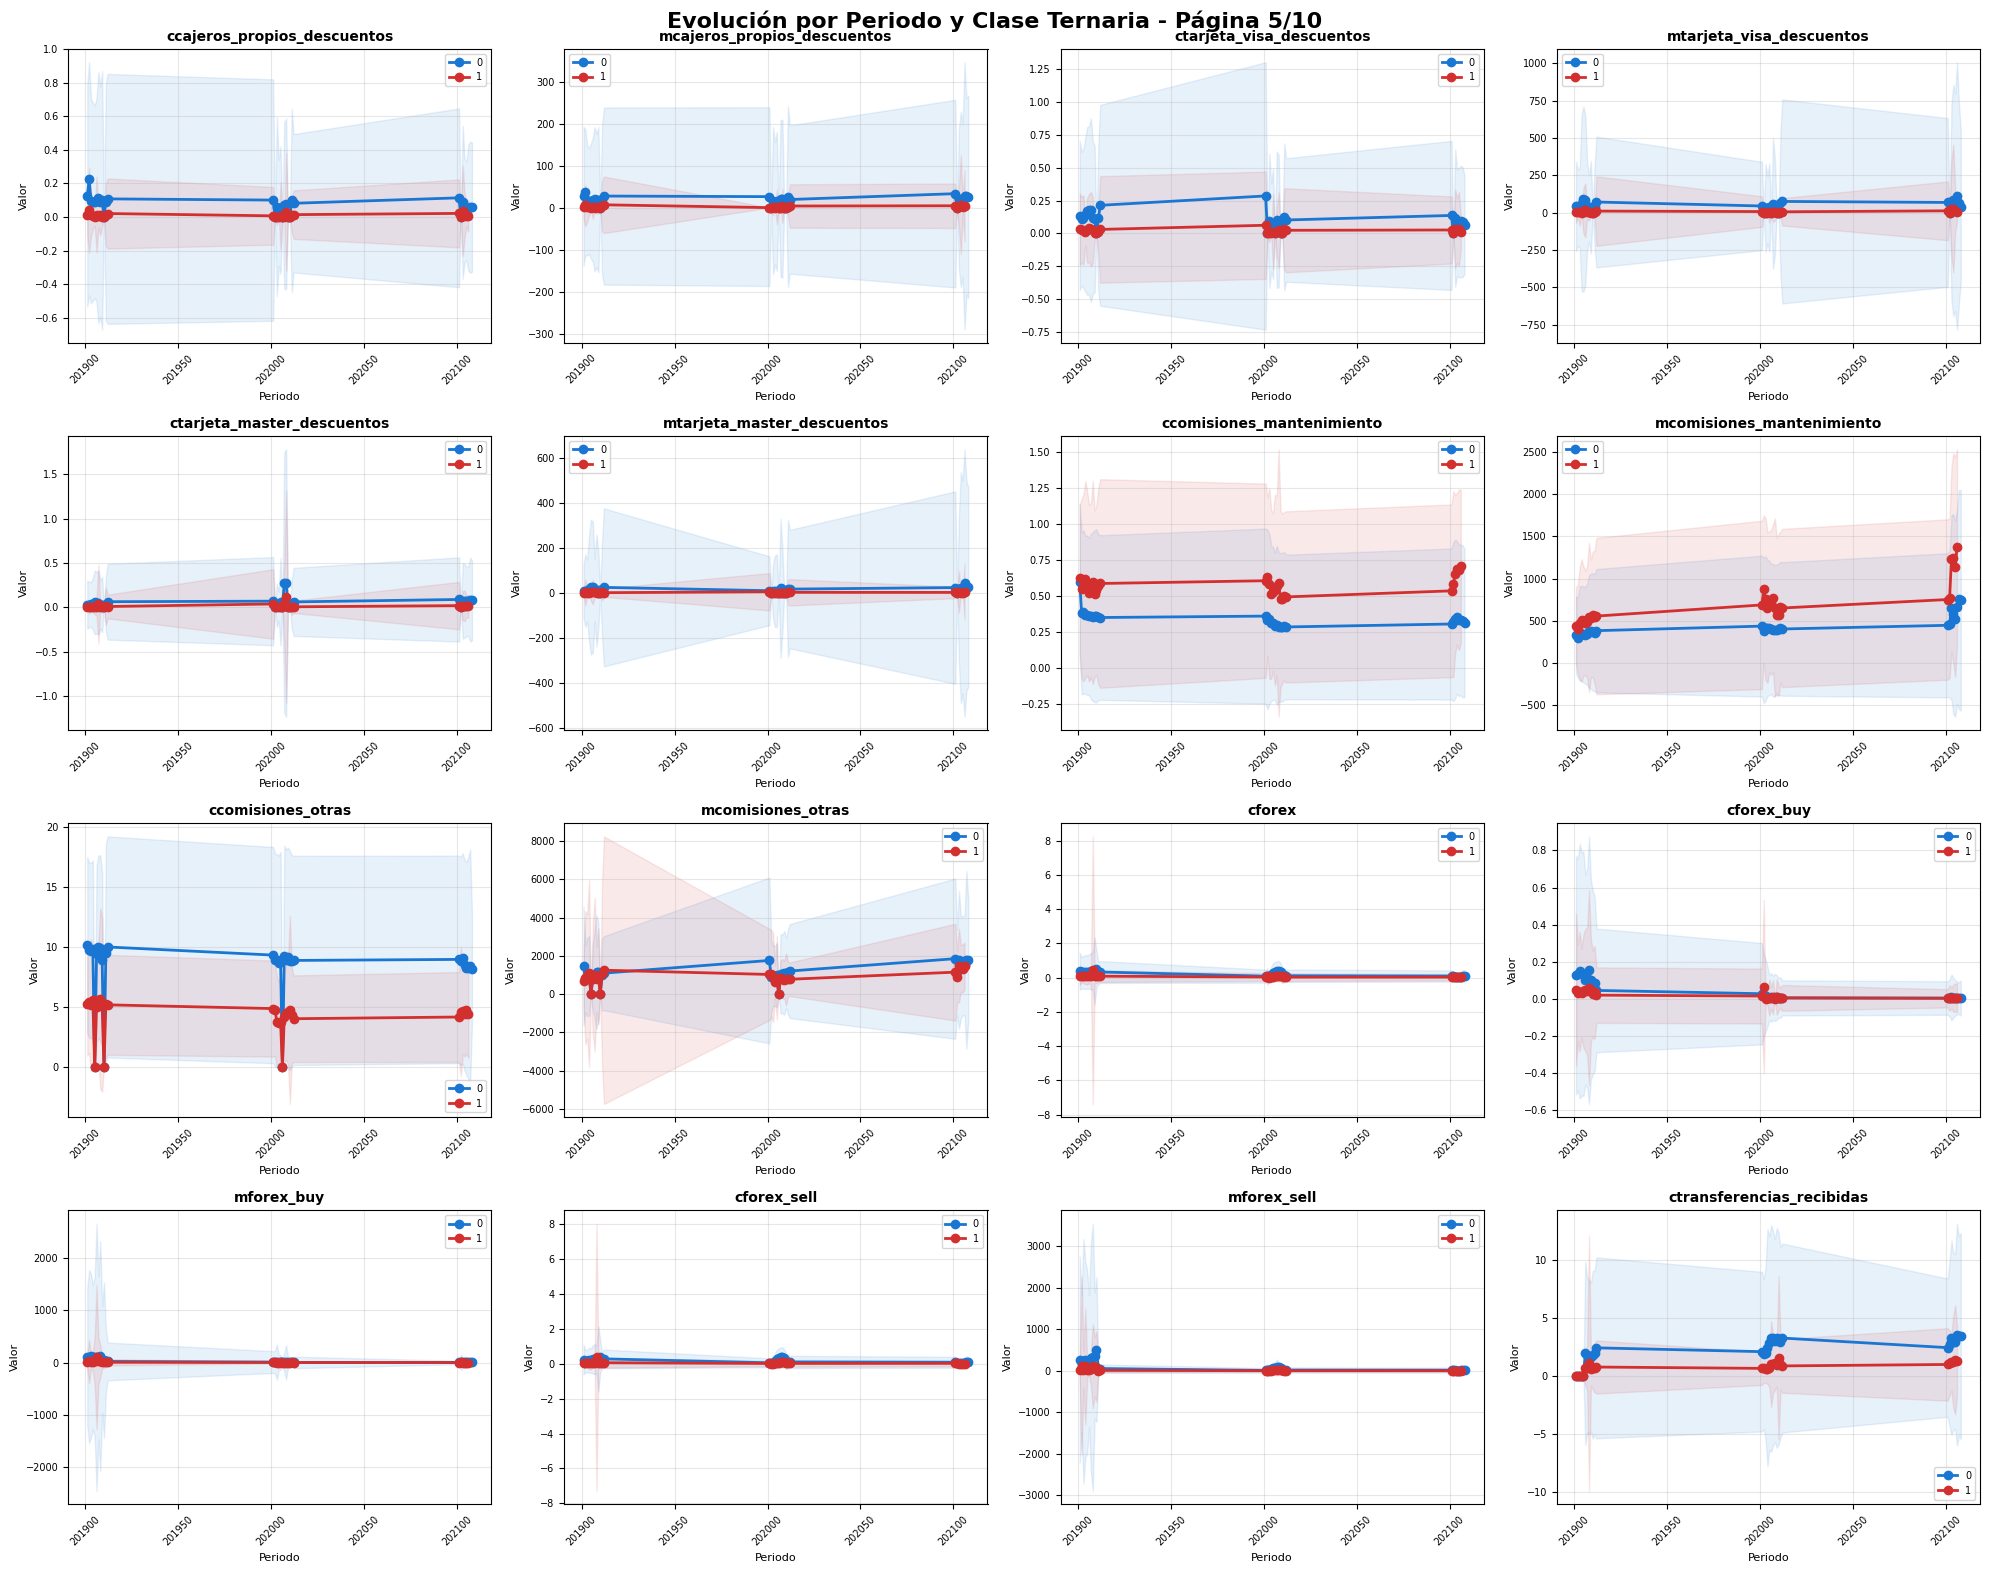

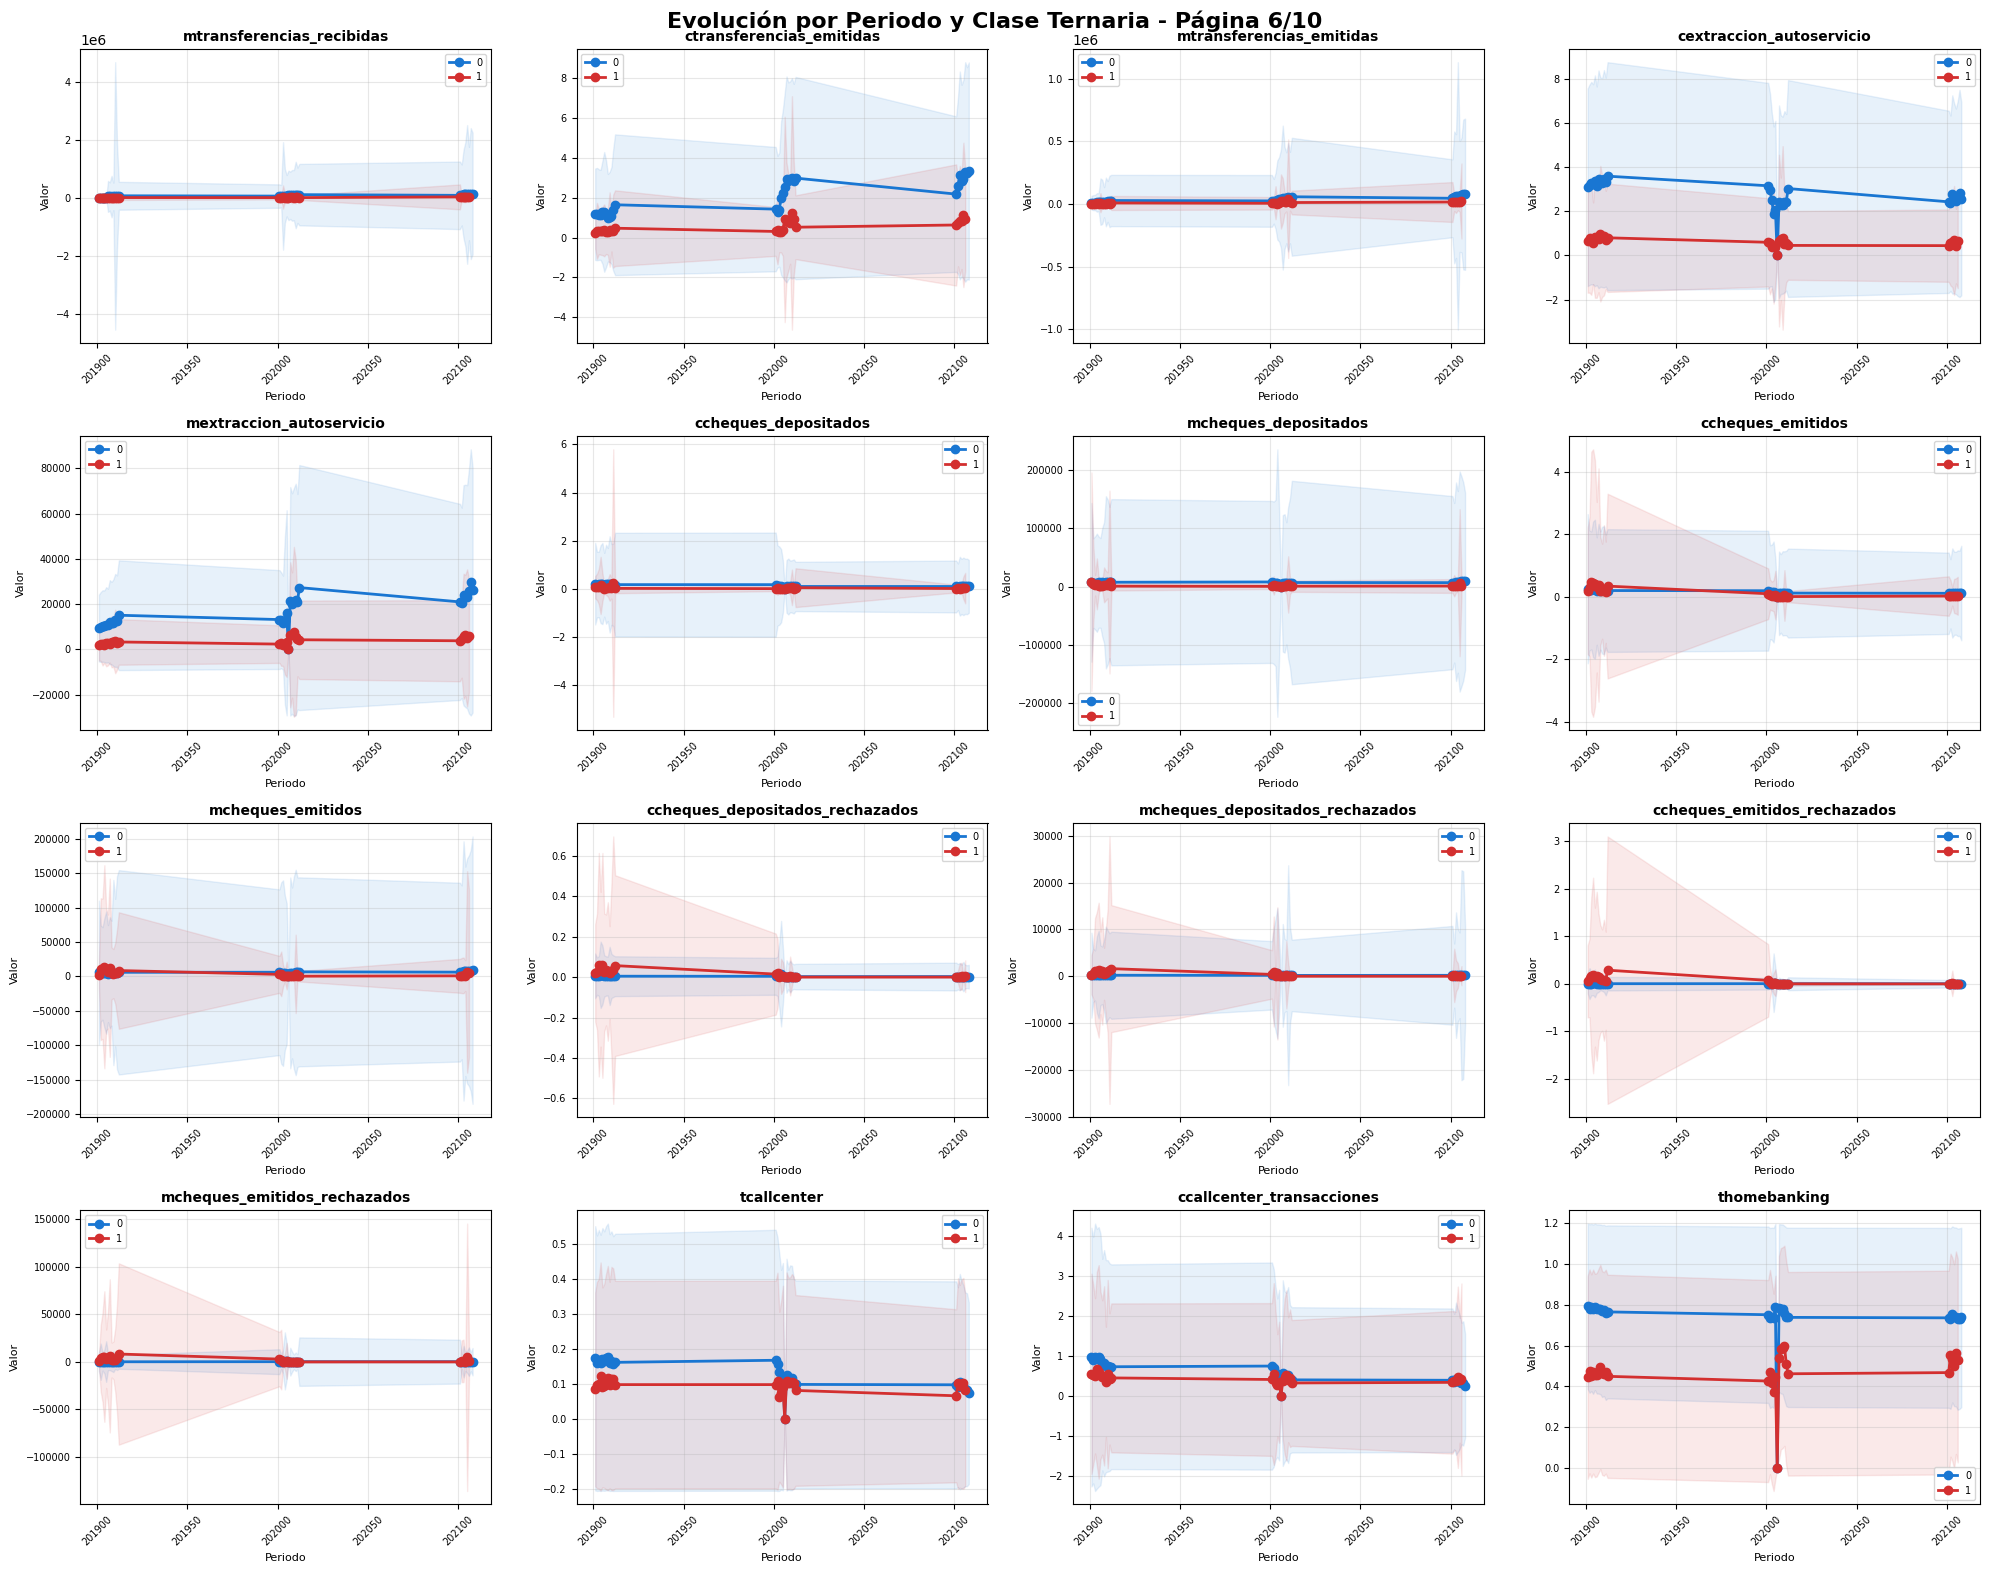

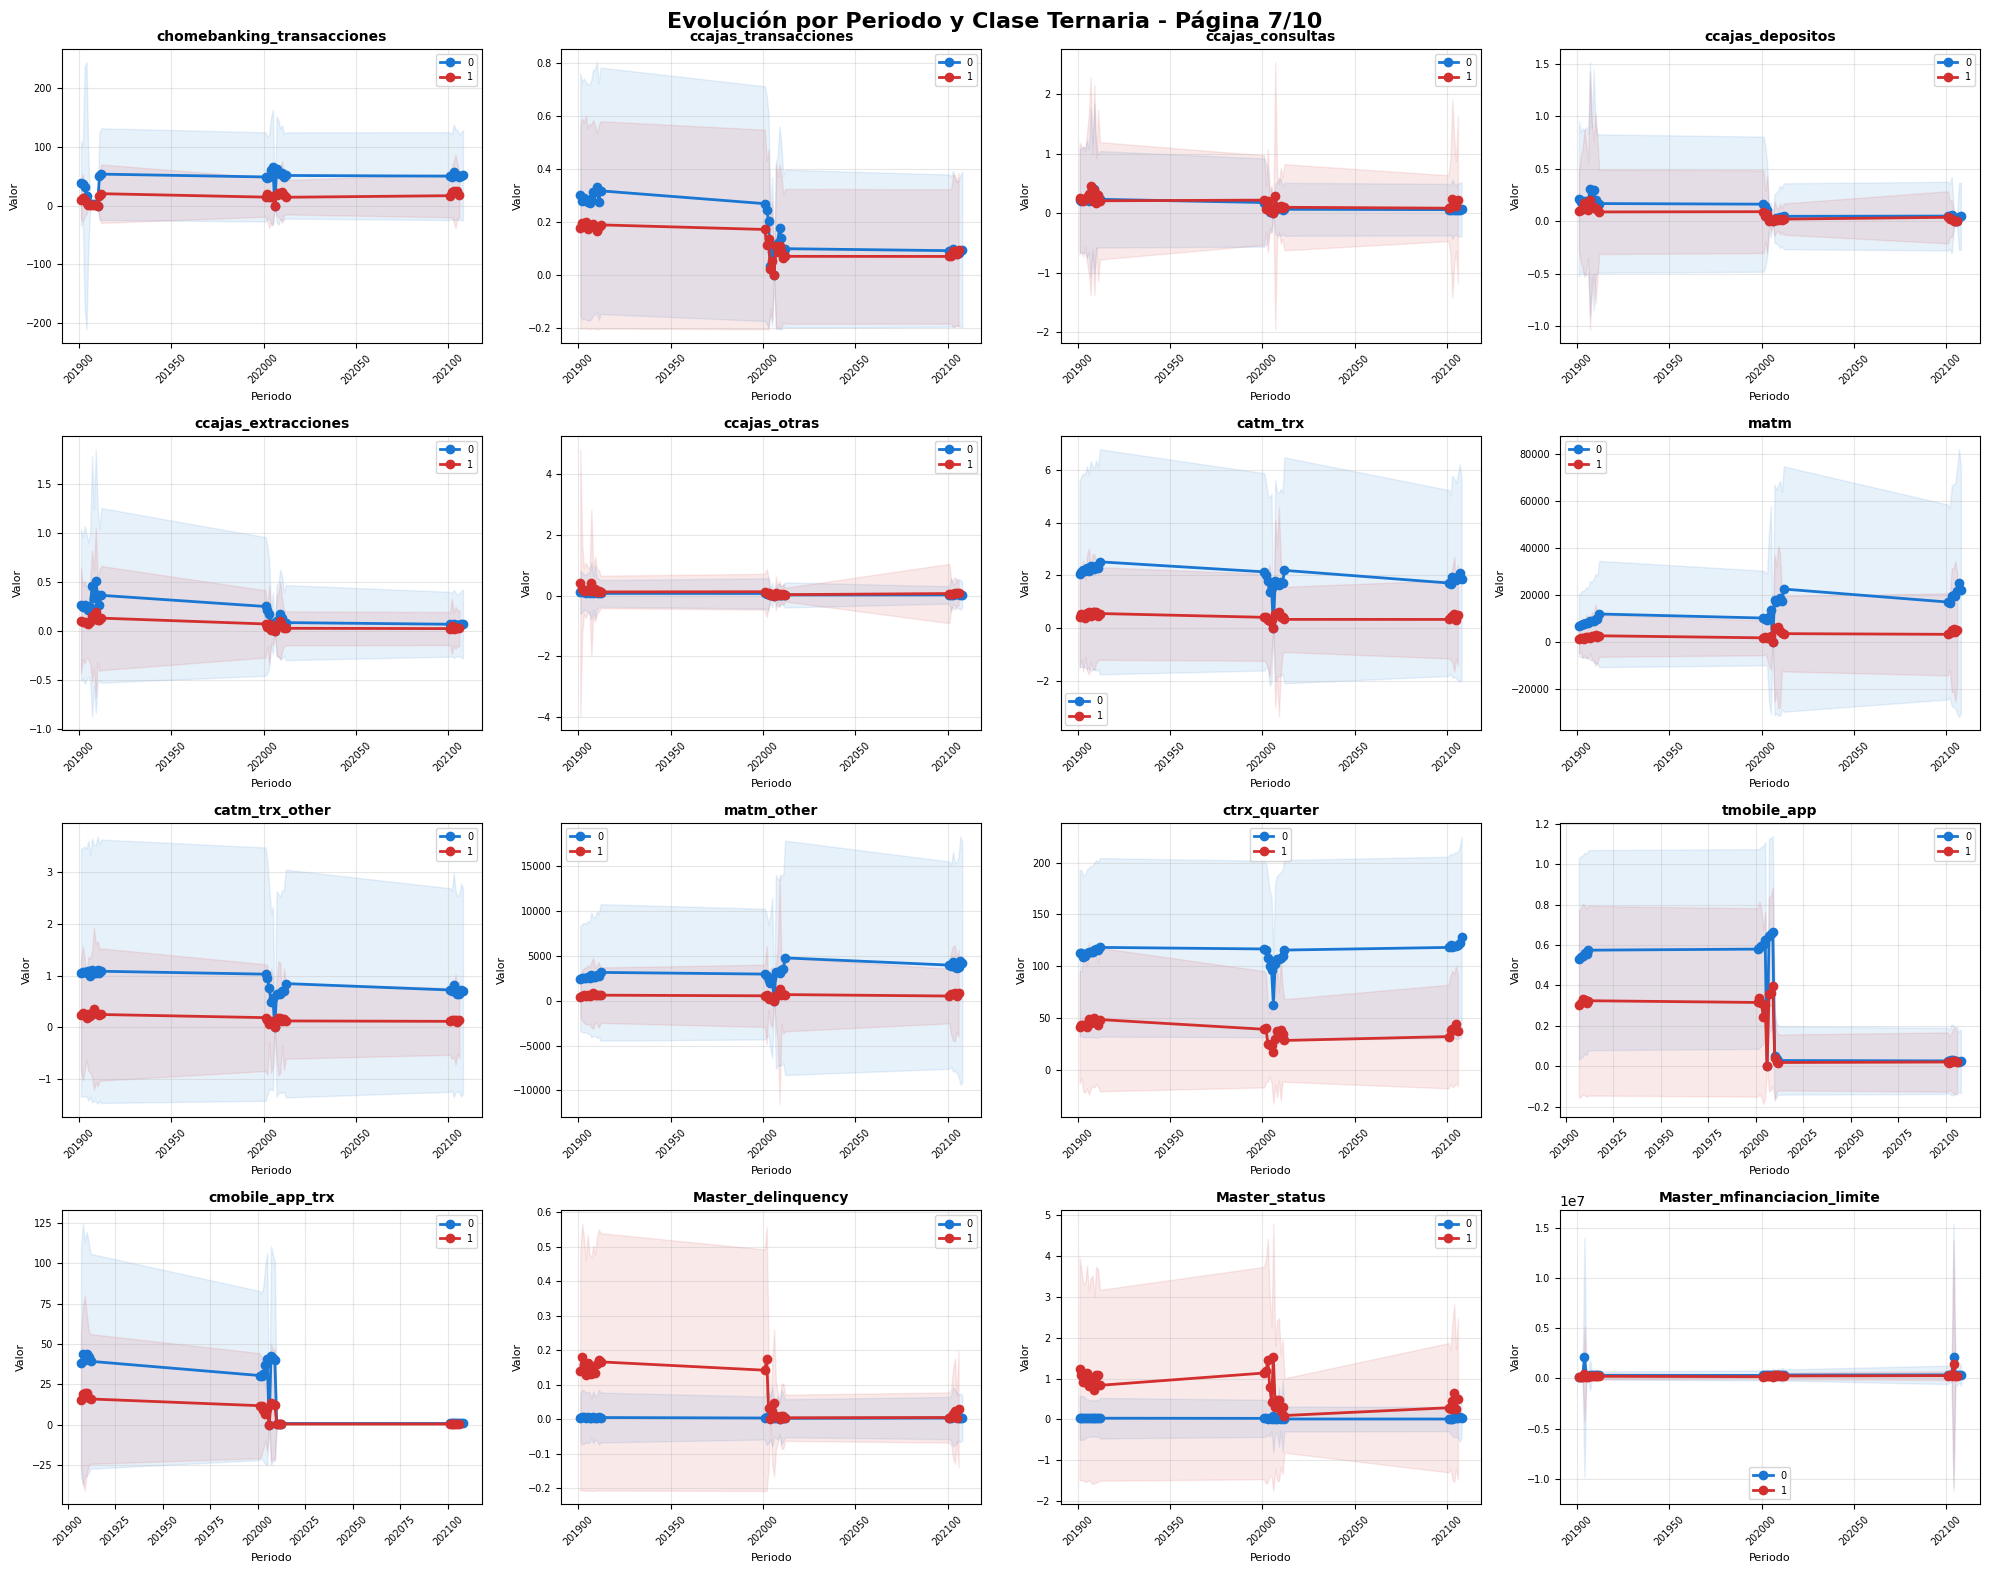

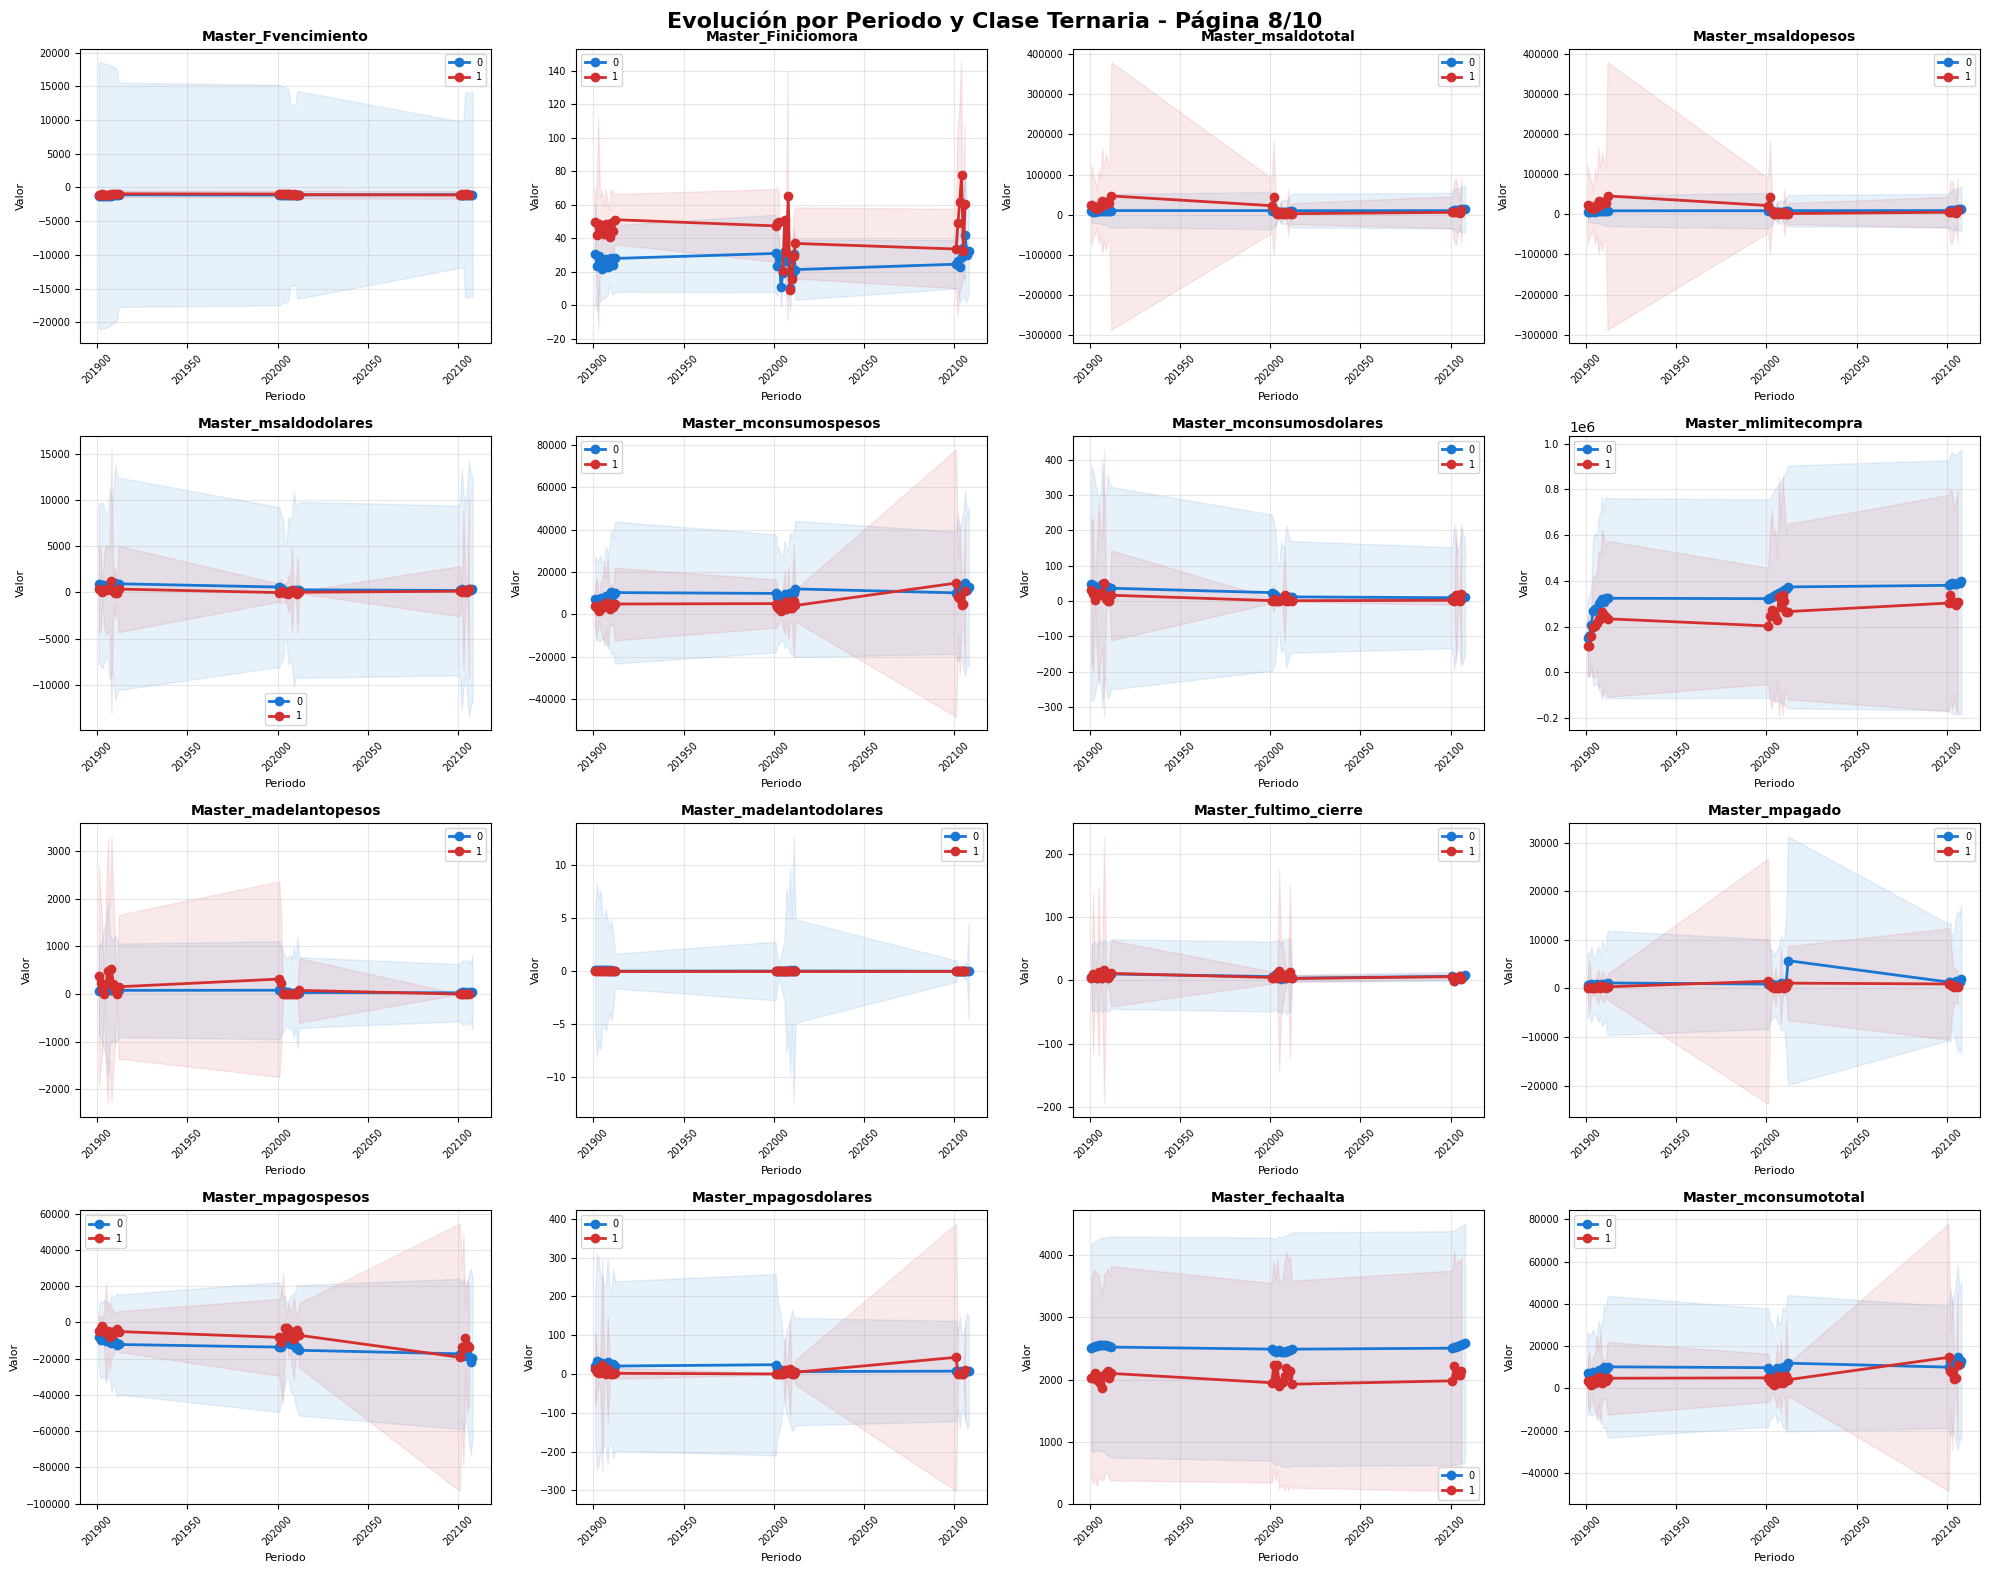

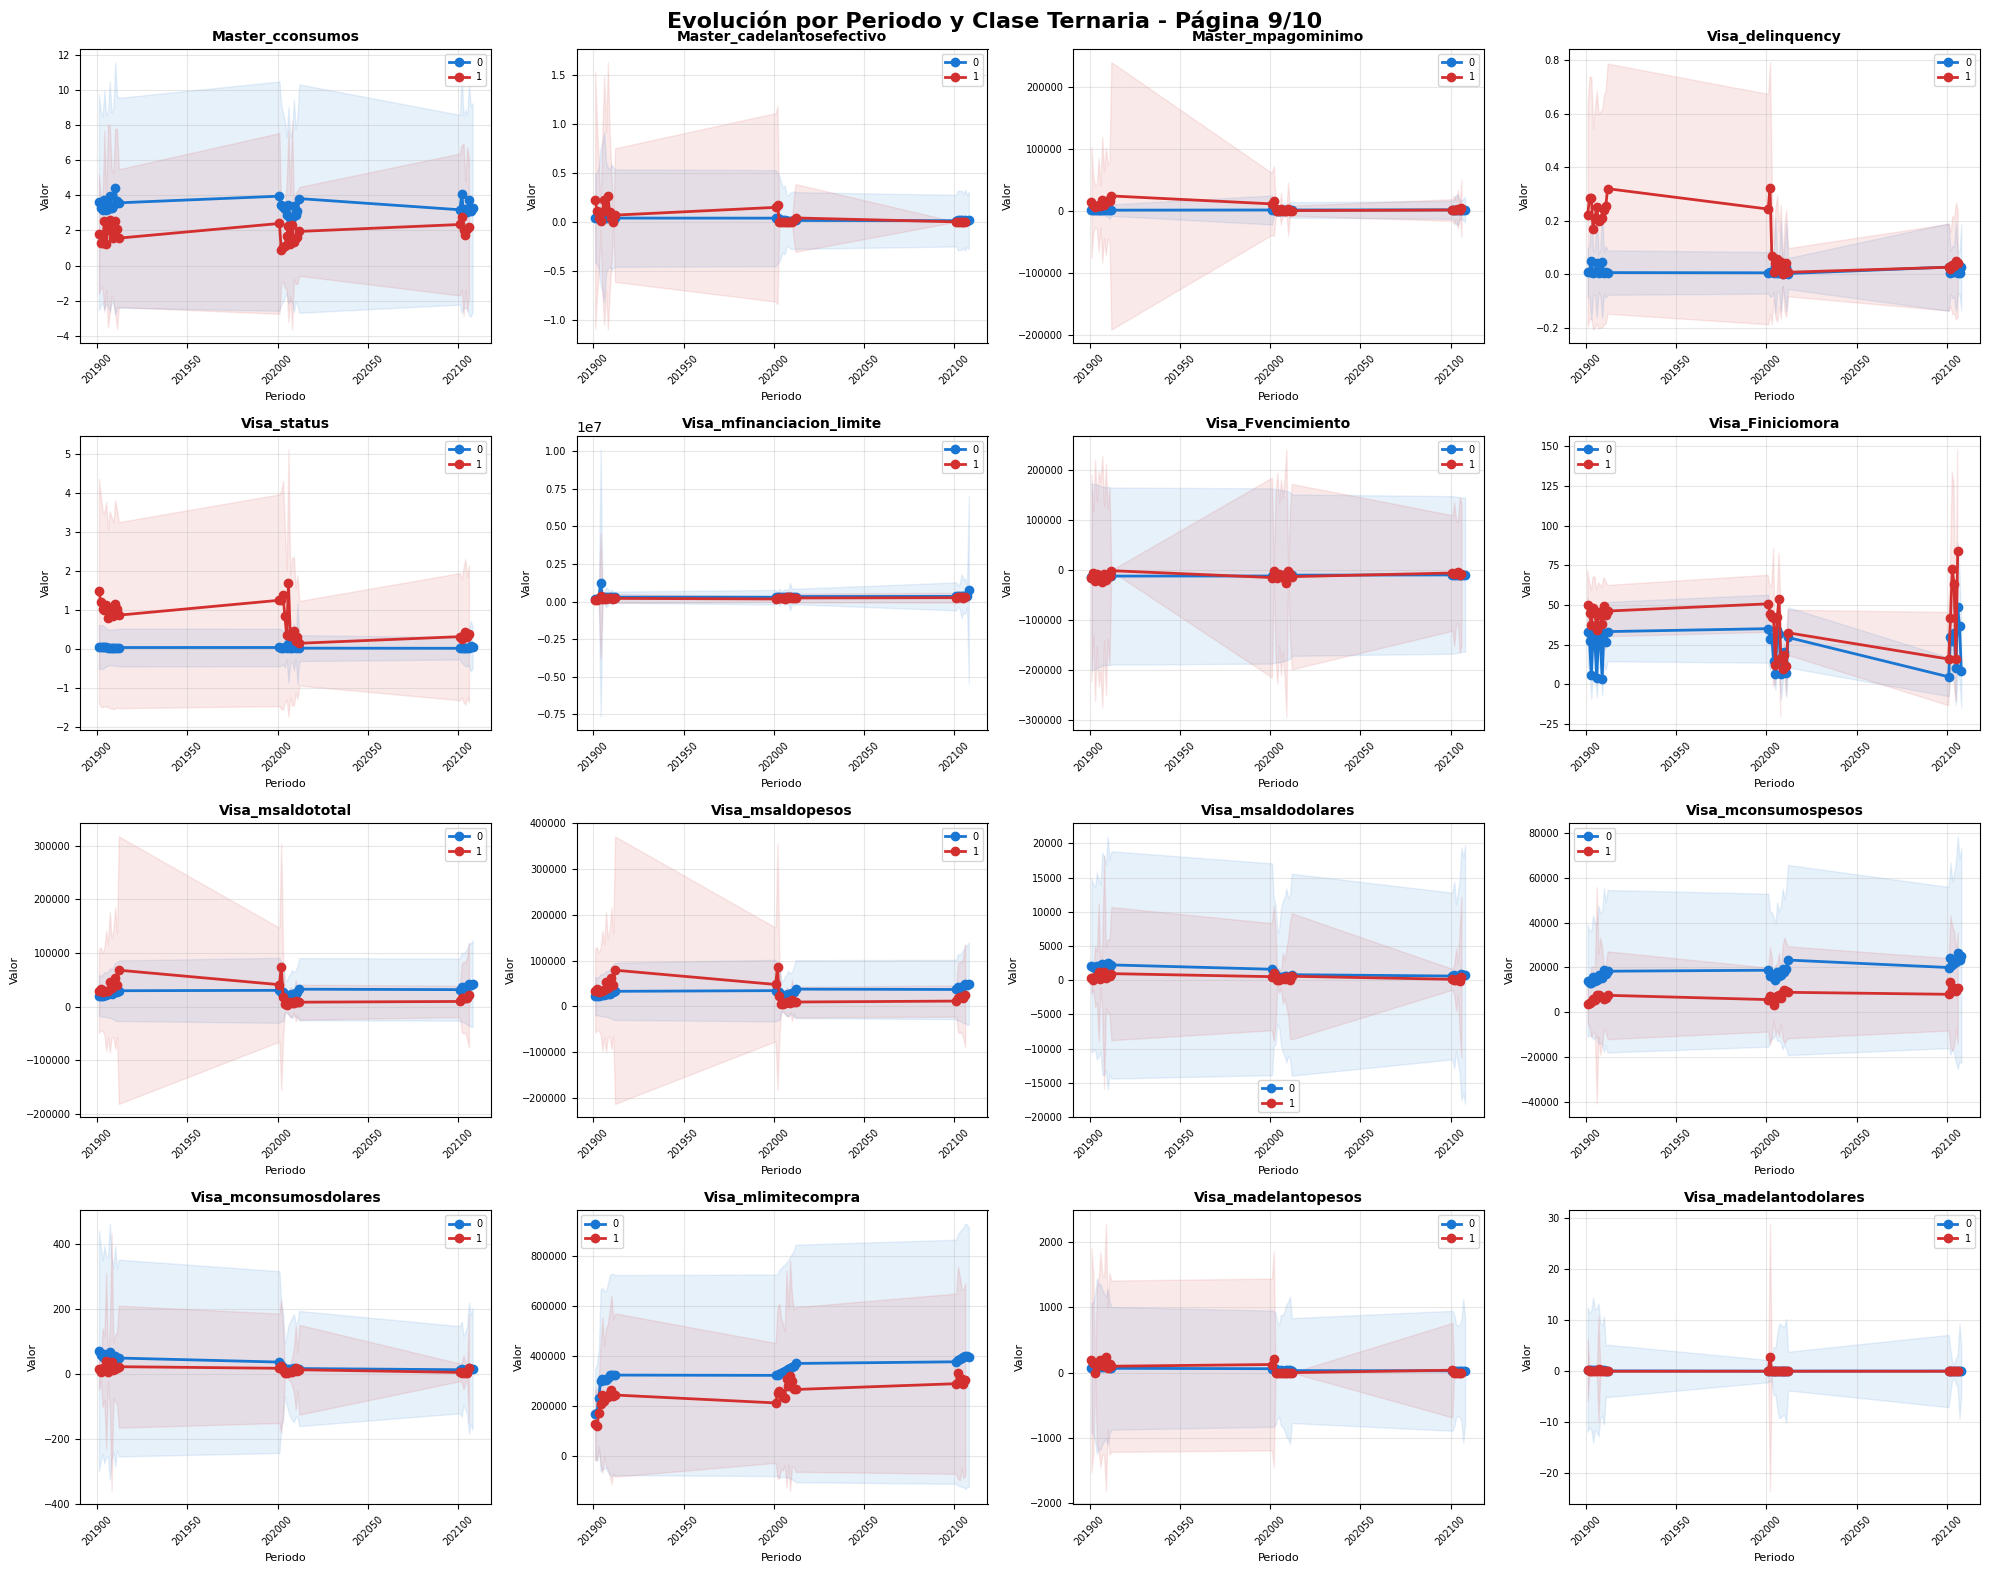

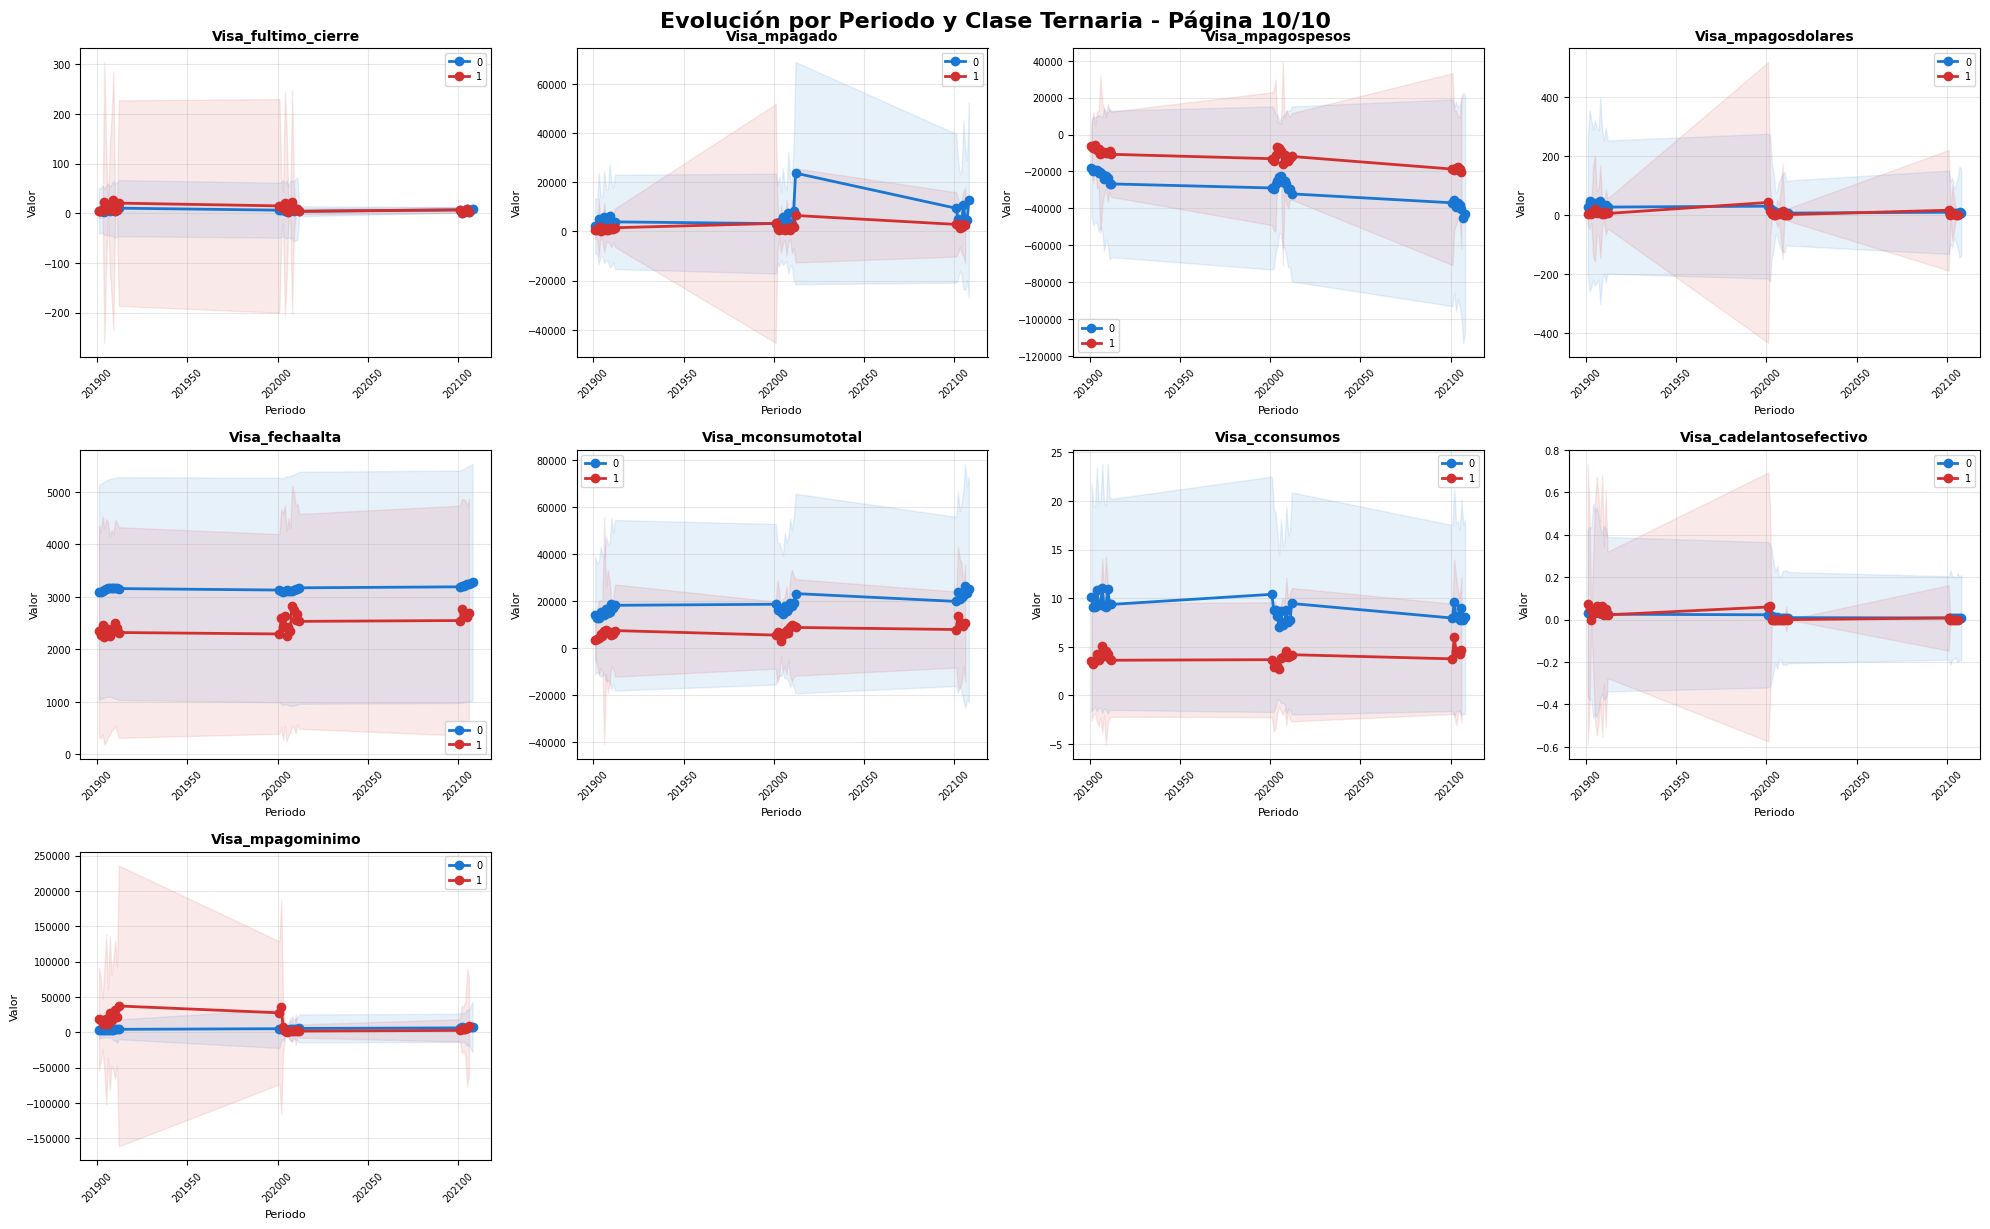


✅ Completado!

ANÁLISIS DE CAMBIOS ENTRE PRIMER Y ÚLTIMO PERIODO (POR CLASE)

📊 CLASE: 0
--------------------------------------------------------------------------------

🔴 TOP 5 VARIABLES CON MAYOR CAMBIO:
                 Variable  Media_Inicial   Media_Final      Cambio_%
mtransferencias_recibidas      25.127490 155373.388800 618240.260115
ctransferencias_recibidas       0.001724      3.425271 198572.144535
                mpayroll2       0.486587     68.946146  14069.322698
 mtransferencias_emitidas   11144.857470  78496.469172    604.329054
             Visa_mpagado    2065.059308  12683.377318    514.189494

📊 CLASE: 1
--------------------------------------------------------------------------------

🔴 TOP 5 VARIABLES CON MAYOR CAMBIO:
                Variable  Media_Inicial  Media_Final     Cambio_%
     minversion1_dolares       0.119767    92.807425 77390.107499
          mcuentas_saldo    -814.236859 33109.540088  4166.327842
 mprestamos_hipotecarios     230.849040  8622.8182

In [25]:
# ============================================
# CARGAR DATOS
# ============================================
periodo_col = 'foto_mes'
clase_col = 'clase_ternaria'

# Identificar columnas numéricas
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
columnas_numericas = [c for c in columnas_numericas if c not in [periodo_col, clase_col, 'cliente']]

print(f"Total de variables numéricas: {len(columnas_numericas)}")
print(f"Periodos: {sorted(df[periodo_col].unique())}")
print(f"Clases: {sorted(df[clase_col].unique())}")

# ============================================
# CALCULAR ESTADÍSTICOS POR PERIODO Y CLASE
# ============================================
stats_por_periodo_clase = df.groupby([periodo_col, clase_col])[columnas_numericas].agg(['mean', 'std'])

# ============================================
# CREAR GRÁFICOS
# ============================================
vars_por_pagina = 16

# Calcular número de páginas necesarias
num_paginas = int(np.ceil(len(columnas_numericas) / vars_por_pagina))

print(f"\nGenerando {num_paginas} figuras con gráficos...")

for pagina in range(num_paginas):
    # Variables para esta página
    inicio = pagina * vars_por_pagina
    fin = min(inicio + vars_por_pagina, len(columnas_numericas))
    vars_pagina = columnas_numericas[inicio:fin]
    
    # Crear figura
    filas = 4
    cols = 4
    fig, axes = plt.subplots(filas, cols, figsize=(20, 16))
    fig.suptitle(f'Evolución por Periodo y Clase Ternaria - Página {pagina + 1}/{num_paginas}', 
                 fontsize=16, fontweight='bold')
    
    # Aplanar axes para iterar fácilmente
    axes_flat = axes.flatten()
    
    clases = sorted(df[clase_col].unique())
    color_map = {1: '#D32F2F', 0: '#1976D2'} 
    
    for idx, var in enumerate(vars_pagina):
        ax = axes_flat[idx]
        
        # Graficar cada clase
        for clase in clases:
            try:
                # Filtrar datos para esta clase
                datos_clase = stats_por_periodo_clase.xs(clase, level=1)
                
                medias = datos_clase[var]['mean']
                stds = datos_clase[var]['std']
                periodos = medias.index
                
                # Graficar media
                ax.plot(periodos, medias, marker='o', linewidth=2, 
                       label=f'{clase}', color=color)
                
                # Agregar banda de desviación estándar (más transparente)
                ax.fill_between(periodos, 
                               medias - stds, 
                               medias + stds, 
                               alpha=0.1, 
                               color=color)
            except:
                pass
        
        # Formato
        ax.set_title(var, fontsize=10, fontweight='bold')
        ax.set_xlabel('Periodo', fontsize=8)
        ax.set_ylabel('Valor', fontsize=8)
        ax.tick_params(labelsize=7)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=7, loc='best')
        
        # Rotar etiquetas del eje x si hay muchos periodos
        if len(df[periodo_col].unique()) > 5:
            ax.tick_params(axis='x', rotation=45)
    
    # Ocultar ejes sobrantes
    for idx in range(len(vars_pagina), len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

print(f"\n✅ Completado!")

# ============================================
# RESUMEN DE CAMBIOS POR CLASE
# ============================================
print("\n" + "="*80)
print("ANÁLISIS DE CAMBIOS ENTRE PRIMER Y ÚLTIMO PERIODO (POR CLASE)")
print("="*80)

for clase in clases:
    print(f"\n📊 CLASE: {clase}")
    print("-" * 80)
    
    try:
        datos_clase = stats_por_periodo_clase.xs(clase, level=1)
        
        cambios = []
        for var in columnas_numericas:
            try:
                media_inicial = datos_clase[var]['mean'].iloc[0]
                media_final = datos_clase[var]['mean'].iloc[-1]
                
                if media_inicial != 0:
                    cambio_pct = ((media_final - media_inicial) / abs(media_inicial)) * 100
                else:
                    cambio_pct = 0
                
                cambios.append({
                    'Variable': var,
                    'Media_Inicial': media_inicial,
                    'Media_Final': media_final,
                    'Cambio_%': cambio_pct
                })
            except:
                pass
        
        df_cambios = pd.DataFrame(cambios).sort_values('Cambio_%', key=abs, ascending=False)
        
        print(f"\n🔴 TOP 5 VARIABLES CON MAYOR CAMBIO:")
        print(df_cambios.head(5).to_string(index=False))
    except:
        print(f"   No hay datos suficientes para esta clase")

print("\n" + "="*80)

In [12]:
import polars as pl

In [14]:
df.head()

numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
0          497577435    201904               1            0         1   
1          497579399    201904               1            0         1   
2          497584873    201904               1            0         1   
3          497595300    201904               1            0         1   
4          497595957    201904               1            0         0   

   cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
0            42                 209        1753.50              13568.24   
1            70                 209        2706.48              27226.13   
2            53                 167        1295.07               9201.52   
3            49                 106         656.71               -881.12   
4            75                 209        4538.36              35717.62   

   mcomisiones  ...  Visa_fultimo_cierre  Visa_mpagado  Visa_mpagospesos  \
0       779.76  ...                 20.0      31552.83         -53642.67   
1       194.78  ...                  6.0          0.00          -2065.16   
2       651.73  ...                 20.0      17044.42         -16500.83   
3       503.47  ...                  6.0          0.00         -34603.50   
4      1555.33  ...                 -1.0          0.00         -14880.43   

   Visa_mpagosdolares  Visa_fechaalta  Visa_mconsumototal  Visa_cconsumos  \
0                0.00          5469.0            53391.47            79.0   
1                0.00          4710.0             6429.37             9.0   
2                0.00          4696.0             7190.24            13.0   
3                0.00          3109.0            16088.46            61.0   
4               29.66          5321.0             4649.00             8.0   

   Visa_cadelantosefectivo  Visa_mpagominimo  clase_ternaria  
0                      0.0           5571.75               0  
1                      0.0            434.01               0  
2                      0.0           1032.24               0  
3                      0.0           1958.91               0  
4                      0.0           1149.54               0  

[5 rows x 155 columns]

In [17]:
col = [c for c in df.columns if c not in ['numero_de_cliente', 'foto_mes', 'clase_ternaria']]

In [18]:
import polars as pl
import gc

def feature_engineering_rolling_mean_fast(df, columnas_validas, ventana=3):
    df_pl = pl.from_pandas(df).lazy()

    # Crear periodo0 si no existe
    if 'periodo0' not in df.columns:
        df_pl = df_pl.with_columns(
            ((pl.col("foto_mes") // 100) * 12 + (pl.col("foto_mes") % 100)).alias("periodo0")
        )
        drop_periodo0 = True
    else:
        drop_periodo0 = False

    # Expresiones rolling
    expresiones = [
        pl.col(col).shift(1)
        .rolling_mean(window_size=ventana, min_periods=1)
        .over("numero_de_cliente", order_by="periodo0")
        .alias(f"{col}_rolling_mean_{ventana}")
        for col in columnas_validas
    ]

    df_pl = df_pl.with_columns(expresiones)

    if drop_periodo0:
        df_pl = df_pl.drop("periodo0")

    df_result = df_pl.collect().to_pandas()
    gc.collect()
    return df_result

In [20]:
import time

start = time.time()
df = feature_engineering_rolling_mean(df, col, ventana=3)
end = time.time()

print(f"Tiempo transcurrido: {end - start:.2f} segundos")

Procesando 152 columnas con Polars (4M filas)...
Calculando periodo0 para manejo correcto de cambios de año...
Aplicando 152 transformaciones...
Ejecutando query optimizada...


/tmp/ipykernel_11551/3639619599.py:37: DeprecationWarning: the argument `min_periods` for `Expr.rolling_mean` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  .rolling_mean(window_size=ventana, min_periods=1)


✅ Completado: (4717958, 307)
Tiempo transcurrido: 30.99 segundos


In [21]:
df.head()

numero_de_cliente  foto_mes  active_quarter  cliente_vip  internet  \
0          497577435    201904               1            0         1   
1          497579399    201904               1            0         1   
2          497584873    201904               1            0         1   
3          497595300    201904               1            0         1   
4          497595957    201904               1            0         0   

   cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
0            42                 209        1753.50              13568.24   
1            70                 209        2706.48              27226.13   
2            53                 167        1295.07               9201.52   
3            49                 106         656.71               -881.12   
4            75                 209        4538.36              35717.62   

   mcomisiones  ...  Visa_madelantodolares_rolling_mean_3  \
0       779.76  ...                                   0.0   
1       194.78  ...                                   0.0   
2       651.73  ...                                   0.0   
3       503.47  ...                                   0.0   
4      1555.33  ...                                   0.0   

   Visa_fultimo_cierre_rolling_mean_3  Visa_mpagado_rolling_mean_3  \
0                                23.0                 32543.390625   
1                                 9.0                   688.386658   
2                                23.0                 12196.046875   
3                                 9.0                  3910.000000   
4                                 2.0                     0.000000   

   Visa_mpagospesos_rolling_mean_3  Visa_mpagosdolares_rolling_mean_3  \
0                    -44840.535156                           0.000000   
1                     -9351.269531                          59.676666   
2                     -9041.506836                           0.000000   
3                    -27003.316406                          35.856667   
4                    -17639.824219                          46.546665   

   Visa_fechaalta_rolling_mean_3  Visa_mconsumototal_rolling_mean_3  \
0                         5409.0                       28527.212891   
1                         4650.0                         730.340027   
2                         4636.0                        7830.169922   
3                         3049.0                       12918.516602   
4                         5261.0                        6579.700195   

   Visa_cconsumos_rolling_mean_3  Visa_cadelantosefectivo_rolling_mean_3  \
0                      47.666668                                     0.0   
1                       6.000000                                     0.0   
2                      12.333333                                     0.0   
3                      51.666668                                     0.0   
4                      13.000000                                     0.0   

   Visa_mpagominimo_rolling_mean_3  
0                      4015.570068  
1                       320.619995  
2                       782.000000  
3                      3949.100098  
4                      1294.209961  

[5 rows x 307 columns]

In [28]:
cols = ['numero_de_cliente', 'foto_mes', 'mrentabilidad', 'mrentabilidad_rolling_mean_3']  # poné las que quieras ver
df.loc[df['numero_de_cliente'] == 497577435, cols].sort_values('foto_mes')

numero_de_cliente  foto_mes  mrentabilidad  \
273460           497577435    201901        2041.38   
326144           497577435    201902        1194.17   
1158123          497577435    201903        2760.06   
0                497577435    201904        1753.50   
241249           497577435    201905           0.00   
454642           497577435    201906        2053.96   
474957           497577435    201907        1292.81   
670957           497577435    201908         -78.74   
803277           497577435    201909       -1301.44   
1096982          497577435    201910           0.00   
1990902          497577435    201911        4906.30   
1211539          497577435    201912        4725.73   
1345628          497577435    202001         744.38   
1485232          497577435    202002          50.30   
2555697          497577435    202003       -1742.89   
1762444          497577435    202004         313.57   
1911871          497577435    202005       -1818.93   
2148778          497577435    202006           0.00   
2347029          497577435    202007        -542.37   
2897352          497577435    202008        -804.57   
2396527          497577435    202009       -2638.19   
2710059          497577435    202010        -497.44   
3248149          497577435    202011       -1865.53   
2796050          497577435    202012       -3554.57   
4584544          497577435    202101       -3817.78   
3212735          497577435    202102       -3794.47   
3940149          497577435    202103       -3336.75   
3662817          497577435    202104       -2378.12   
3826145          497577435    202105       -2976.62   
4020678          497577435    202106        -927.20   
4452577          497577435    202107        -854.69   
4318698          497577435    202108       -1087.89   

         mrentabilidad_rolling_mean_3  
273460                            NaN  
326144                    2041.380005  
1158123                   1617.775024  
0                         1998.536621  
241249                    1902.576660  
454642                    1504.520020  
474957                    1269.153320  
670957                    1115.589966  
803277                    1089.343384  
1096982                    -29.123333  
1990902                   -460.059998  
1211539                   1201.619995  
1345628                   3210.676758  
1485232                   3458.803223  
2555697                   1840.136719  
1762444                   -316.070007  
1911871                   -459.673340  
2148778                  -1082.750000  
2347029                   -501.786652  
2897352                   -787.099976  
2396527                   -448.980011  
2710059                  -1328.376709  
3248149                  -1313.400024  
2796050                  -1667.053345  
4584544                  -1972.513306  
3212735                  -3079.293213  
3940149                  -3722.273438  
3662817                  -3649.666748  
3826145                  -3169.780029  
4020678                  -2897.163330  
4452577                  -2093.979980  
4318698                  -1586.170044